# Análisis Exploratorio de Datos (EDA)
## Proyecto: Clasificación de Riesgo Crediticio

### Objetivo Principal
Realizar un análisis exploratorio completo de los datos para comprender la estructura, calidad y patrones del dataset de riesgo crediticio, identificando insights clave que guíen el desarrollo del modelo de clasificación.

### Objetivos Específicos:
1. **Análisis de Integridad y Calidad de Datos**
   - Verificar la estructura y tipos de datos del dataset
   - Identificar y cuantificar valores faltantes entre train y test
   - Analizar estadísticas descriptivas y detectar outliers

2. **Exploración de Patrones y Relaciones**
   - Analizar la distribución de la variable objetivo y balance de clases
   - Estudiar correlaciones entre variables predictoras y con el target
   - Examinar distribuciones de features por categorías y clases de riesgo

3. **Evaluación para Preparación de Modelado**
   - Identificar las variables más predictivas del nivel de riesgo
   - Determinar estrategias de preprocessing necesarias
   - Establecer oportunidades de feature engineering

**Clases objetivo:**
- 0: Bajo riesgo
- 1: Riesgo medio  
- 2: Alto riesgo

**Dataset:** 20,000 instancias con 35 características divididas en:
- Información Financiera (15 features)
- Historial de Pagos (10 features)
- Datos Demográficos y Comportamiento (10 features)

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

project_root = os.path.abspath('..')
sys.path.insert(0, os.path.join(project_root, 'src'))

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

from data.loader import (
    load_training_data, 
    load_test_data, 
    get_feature_info, 
    separate_features_target,
    encode_target_labels,
    check_missing_values,
    detect_outliers_iqr
)

## 1. Data load y Verificación de Integridad

### 1.1 Utilities (Funciones)

In [2]:
# Funciones para cargar y explorar datos
def load_and_display_data_info():
    train_path = os.path.join(project_root, 'data', 'raw', 'datos_entrenamiento_riesgo.csv')
    test_path = os.path.join(project_root, 'data', 'raw', 'datos_prueba_riesgo.csv')
    train_data = load_training_data(train_path)
    test_data = load_test_data(test_path)

    print(f"Datos de entrenamiento: {train_data.shape}")
    print(f"Datos de prueba: {test_data.shape}")
    print("\n--- Información del Dataset de Entrenamiento ---")
    print(train_data.info())
    print("\n--- Primeras 5 filas ---")
    display(train_data.head())
    
    return train_data, test_data

# Función para identificar tipos de variables

def identify_variable_types(data):
    numerical_features = [col for col in data.columns if col != 'nivel_riesgo' and 
                         data[col].dtype in ['int64', 'float64']]
    categorical_features = [col for col in data.columns if col != 'nivel_riesgo' and 
                           data[col].dtype == 'object']
    
    print(f"Features numéricas ({len(numerical_features)}): {numerical_features[:5]}...")
    print(f"Features categóricas ({len(categorical_features)}): {categorical_features[:5]}...")
    print(f"\nMappeo de target: Bajo=0, Medio=1, Alto=2")
    print(f"Distribución codificada: {encode_target_labels(data['nivel_riesgo']).value_counts().sort_index().to_dict()}")
    
    return numerical_features, categorical_features

In [3]:
# Función para verificar integridad de la variable objetivo
def verify_target_integrity(data):
    """Verifica la integridad de la variable objetivo"""
    print("Valores únicos en nivel_riesgo:")
    print(data['nivel_riesgo'].unique())
    print(f"\nCantidades por clase:")
    print(data['nivel_riesgo'].value_counts())
    print(f"\nValores nulos en target: {data['nivel_riesgo'].isnull().sum()}")
    print(f"Tipo de datos del target: {data['nivel_riesgo'].dtype}")
    print(f"\nPrimeras 10 muestras del target:")
    print(data['nivel_riesgo'].head(10).tolist())

### 1.2 Carga de Datos y Features

In [4]:
train_data, test_data = load_and_display_data_info()

Datos de entrenamiento: (20000, 35)
Datos de prueba: (5000, 35)

--- Información del Dataset de Entrenamiento ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   deuda_total                         20000 non-null  float64
 1   proporcion_ingreso_deuda            20000 non-null  float64
 2   monto_solicitado                    20000 non-null  float64
 3   tasa_interes                        20000 non-null  float64
 4   lineas_credito_abiertas             19795 non-null  float64
 5   saldo_promedio_bancario             20000 non-null  float64
 6   ingresos_familiares_per_capita      20000 non-null  float64
 7   puntuacion_credito_bureau           20000 non-null  float64
 8   antiguedad_laboral_meses            20000 non-null  int64  
 9   patrimonio_neto                     20000 non-null  float

,deuda_total,proporcion_ingreso_deuda,monto_solicitado,tasa_interes,lineas_credito_abiertas,saldo_promedio_bancario,ingresos_familiares_per_capita,puntuacion_credito_bureau,antiguedad_laboral_meses,patrimonio_neto,...,nivel_educativo,estado_civil,numero_dependientes,propiedad_vivienda,tipo_vivienda,residencia_antiguedad_meses,sector_laboral,numero_empleos_ultimos_5_anos,frecuencia_transacciones_mensuales,nivel_riesgo
0,264963.261472,2.558188,224689.970169,412718.904936,1.0,617000.655828,784371.839561,431.472686,63,579054.186683,...,1.0,0.0,4,1,0.0,3.0,5.0,0,184,Medio
1,11489.554688,4.068588,340775.397601,134594.323820,3.0,615109.565461,612019.770231,769.709848,132,979346.226262,...,5.0,1.0,1,3,5.0,5.0,2.0,1,33,Bajo
2,723302.929780,4.822340,339093.283806,366302.670205,6.0,290722.132266,450139.718347,603.495294,430,96494.531775,...,3.0,0.0,1,2,3.0,3.0,1.0,1,293,Alto
3,860369.349430,3.916943,376398.086975,682877.468407,2.0,278509.345990,938593.353343,622.461619,320,136862.479683,...,3.0,1.0,5,3,3.0,2.0,2.0,5,482,Alto
4,165656.532005,2.662927,532351.607061,370399.546017,1.0,799624.680649,474263.676188,841.087629,398,748688.607413,...,5.0,3.0,0,0,4.0,0.0,4.0,4,713,Bajo


In [5]:
numerical_features, categorical_features = identify_variable_types(train_data)

Features numéricas (34): ['deuda_total', 'proporcion_ingreso_deuda', 'monto_solicitado', 'tasa_interes', 'lineas_credito_abiertas']...
Features categóricas (0): []...

Mappeo de target: Bajo=0, Medio=1, Alto=2
Distribución codificada: {0: 5968, 1: 11017, 2: 3015}


### 1.3 Verificación de Integridad de Variable Objetivo

In [6]:
verify_target_integrity(train_data)

Valores únicos en nivel_riesgo:
['Medio' 'Bajo' 'Alto']

Cantidades por clase:
nivel_riesgo
Medio    11017
Bajo      5968
Alto      3015
Name: count, dtype: int64

Valores nulos en target: 0
Tipo de datos del target: object

Primeras 10 muestras del target:
['Medio', 'Bajo', 'Alto', 'Alto', 'Bajo', 'Bajo', 'Medio', 'Alto', 'Medio', 'Medio']


## 2. Análisis de la Variable Objetivo

### 2.1 Utilities (Funciones)

In [7]:
def analyze_target_distribution(data):
    """Analiza y visualiza la distribución de la variable objetivo"""
    target_counts = data['nivel_riesgo'].value_counts()
    target_percentages = data['nivel_riesgo'].value_counts(normalize=True) * 100

    print("Distribución de clases:")
    print(f"Bajo:  {target_counts['Bajo']:,} ({target_percentages['Bajo']:.1f}%)")
    print(f"Medio: {target_counts['Medio']:,} ({target_percentages['Medio']:.1f}%)")
    print(f"Alto:  {target_counts['Alto']:,} ({target_percentages['Alto']:.1f}%)")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    target_counts.plot(kind='bar', ax=ax1, color=['green', 'orange', 'red'])
    ax1.set_title('Distribución de Clases - Conteo')
    ax1.set_xlabel('Nivel de Riesgo')
    ax1.set_ylabel('Número de Instancias')
    ax1.tick_params(axis='x', rotation=0)

    ax2.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', 
            colors=['green', 'orange', 'red'], startangle=90)
    ax2.set_title('Distribución de Clases - Porcentaje')

    plt.tight_layout()
    plt.show()

    print(f"\nRatio de desbalance:")
    print(f"Clase mayoritaria / Clase minoritaria: {target_counts.max() / target_counts.min():.2f}")

### 2.2 Variable Objetivo

Distribución de clases:
Bajo:  5,968 (29.8%)
Medio: 11,017 (55.1%)
Alto:  3,015 (15.1%)


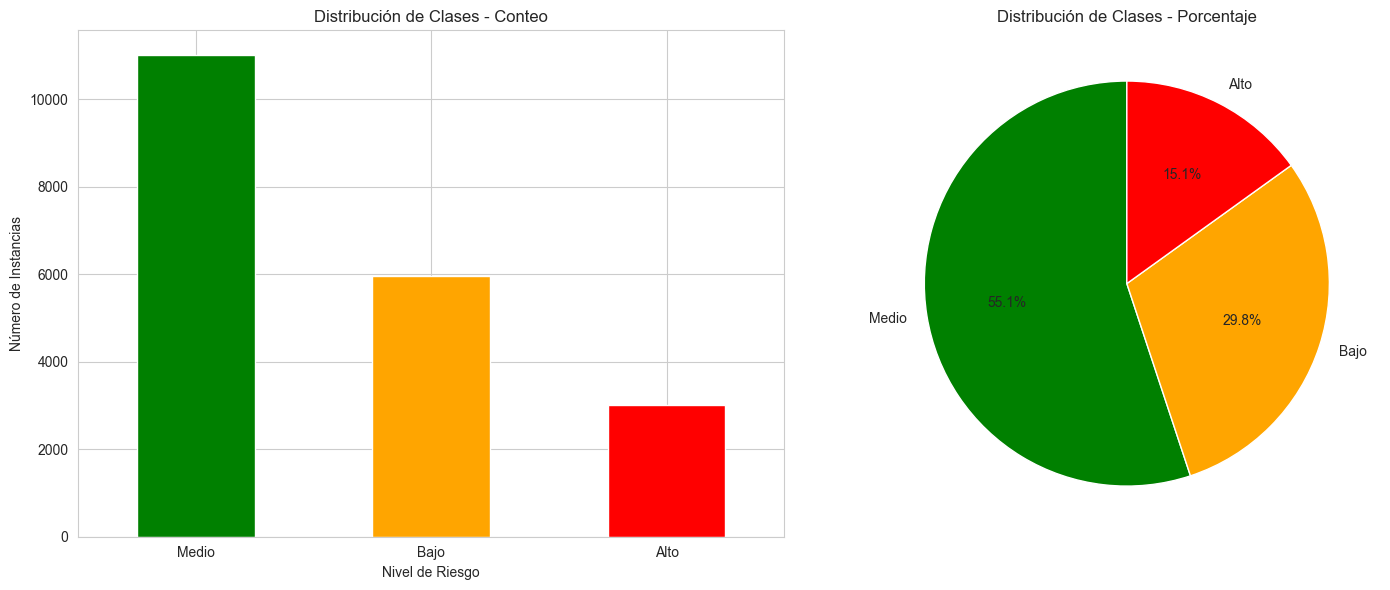


Ratio de desbalance:
Clase mayoritaria / Clase minoritaria: 3.65


In [8]:
analyze_target_distribution(train_data)

### 2.3 Conclusiones del Análisis de la Variable Objetivo

#### Distribución de las Clases
La variable objetivo presenta una distribución desbalanceada moderada:

- **Medio**: 11,017 muestras (55.1%) - Clase mayoritaria
- **Bajo**: 5,968 muestras (29.8%) - Clase intermedia
- **Alto**: 3,015 muestras (15.1%) - Clase minoritaria

#### Insights Clave
##### 1. Desbalance Controlado
- Ratio de desbalance: **3.65** (clase mayoritaria vs minoritaria)
- No es un desbalance extremo (< 10:1), pero sí significativo
- La clase "Alto riesgo" está subrepresentada
##### 2. Implicaciones para el Modelado
- **Precisión**: Los modelos tenderán a predecir mejor las clases "Medio" y "Bajo"
- **Recall**: La clase "Alto" podría tener menor sensibilidad
- **Sesgo**: Riesgo de que el modelo se sesge hacia la clase mayoritaria
##### 3. Distribución Realista
- Refleja la realidad del negocio: la mayoría de clientes tienen riesgo medio-bajo
- Los clientes de alto riesgo son naturalmente menos frecuentes
- Distribución típica en datasets de riesgo crediticio

## 3. Análisis de Valores Faltantes

### 3.1 Utilities (Funciones)

In [9]:
def analyze_missing_values(train_data, test_data):
    """Analiza valores faltantes en los datasets"""
    missing_train = check_missing_values(train_data)
    missing_test = check_missing_values(test_data)

    print("Valores faltantes en datos de entrenamiento:")
    if len(missing_train) > 0:
        display(missing_train)
    else:
        print("No hay valores faltantes en el dataset de entrenamiento")

    print("\nValores faltantes en datos de prueba:")
    if len(missing_test) > 0:
        display(missing_test)
    else:
        print("No hay valores faltantes en el dataset de prueba")

    categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()
    numerical_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

    if 'nivel_riesgo' in categorical_features:
        categorical_features.remove('nivel_riesgo')
    if 'nivel_riesgo' in numerical_features:
        numerical_features.remove('nivel_riesgo')

    print(f"\nFeatures categóricas ({len(categorical_features)}): {categorical_features}")
    print(f"Features numéricas ({len(numerical_features)}): {len(numerical_features)} features")
    
    return categorical_features, numerical_features

### 3.2 Valores Faltantes en los Datasets

In [10]:
categorical_features, numerical_features = analyze_missing_values(train_data, test_data)

Valores faltantes en datos de entrenamiento:


,Column,Missing_Count,Missing_Percentage
16,porcentaje_utilizacion_credito,927,4.635
31,sector_laboral,834,4.170
21,proporcion_pagos_a_tiempo,421,2.105
29,tipo_vivienda,349,1.745
30,residencia_antiguedad_meses,335,1.675
25,nivel_educativo,307,1.535
26,estado_civil,262,1.310
4,lineas_credito_abiertas,205,1.025



Valores faltantes en datos de prueba:


,Column,Missing_Count,Missing_Percentage
31,sector_laboral,230,4.60
16,porcentaje_utilizacion_credito,218,4.36
4,lineas_credito_abiertas,200,4.00
21,proporcion_pagos_a_tiempo,99,1.98
25,nivel_educativo,99,1.98
29,tipo_vivienda,96,1.92
30,residencia_antiguedad_meses,86,1.72
26,estado_civil,80,1.60



Features categóricas (0): []
Features numéricas (34): 34 features


### 3.3 Conclusiones del Análisis de Valores Faltantes


#### Estado General
- **Dataset de alta calidad**: Ninguna variable supera el 5% de valores faltantes
- **Patrones consistentes** entre datos de entrenamiento y prueba
- **Manejable para el modelado**: Los porcentajes permiten imputación efectiva

#### Variables Más Afectadas
- **porcentaje_utilizacion_credito** (4.6%): Información financiera clave
- **sector_laboral** (4.2%): Datos demográficos  
- **Resto < 2.5%**: Impacto mínimo en el análisis

#### Observación Importante
- **Inconsistencia en lineas_credito_abiertas**: 1.0% train vs 4.0% test
- Todas las features categóricas ya están codificadas numéricamente

## 4. Estadísticas Descriptivas

### 4.1 Utilities (Funciones)

In [11]:
def show_descriptive_statistics(data, numerical_features):
    """Muestra estadísticas descriptivas y análisis de variabilidad"""
    print("Estadísticas descriptivas - Features numéricas:")
    display(data[numerical_features].describe())

    print("\nFeatures con alta variabilidad (CV > 1.0):")
    numerical_stats = data[numerical_features].describe()
    cv_values = numerical_stats.loc['std'] / numerical_stats.loc['mean']
    high_cv_features = cv_values[cv_values > 1.0].sort_values(ascending=False)
    display(high_cv_features.head(10))

    print(f"\nRango de valores por feature:")
    for feature in numerical_features[:10]:
        min_val = data[feature].min()
        max_val = data[feature].max()
        range_val = max_val - min_val
        print(f"{feature:30}: [{min_val:10.2f}, {max_val:10.2f}] (rango: {range_val:10.2f})")

### 4.2 Estadísticas Descriptivas

In [12]:
show_descriptive_statistics(train_data, numerical_features)

Estadísticas descriptivas - Features numéricas:


,deuda_total,proporcion_ingreso_deuda,monto_solicitado,tasa_interes,lineas_credito_abiertas,saldo_promedio_bancario,ingresos_familiares_per_capita,puntuacion_credito_bureau,antiguedad_laboral_meses,patrimonio_neto,...,edad,nivel_educativo,estado_civil,numero_dependientes,propiedad_vivienda,tipo_vivienda,residencia_antiguedad_meses,sector_laboral,numero_empleos_ultimos_5_anos,frecuencia_transacciones_mensuales
count,20000.000000,20000.000000,20000.000000,20000.000000,19795.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,19693.000000,19738.000000,20000.000000,20000.00000,19651.000000,19665.000000,19166.000000,20000.000000,20000.00000
mean,501101.328139,2.548022,499896.596665,497213.271692,5.011922,498962.089442,496605.607876,574.790138,250.069100,499245.217644,...,53.651900,2.507947,1.490273,2.503600,1.50840,2.508015,2.507450,2.490139,2.512000,500.41870
std,289005.376316,1.416445,287719.859918,289336.213663,2.564054,288693.502561,287948.130456,158.348153,143.617526,287749.672095,...,20.764679,1.719545,1.113934,1.697714,1.11503,1.714413,1.701169,1.713920,1.706136,286.98876
min,45.057898,0.100161,132.848889,18.335525,1.000000,6.593585,113.308970,300.024667,1.000000,107.348049,...,18.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,251253.287412,1.319096,251201.009417,246731.364893,3.000000,249397.291158,248160.144954,437.534315,126.000000,250061.214847,...,36.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,251.00000
50%,504148.933652,2.542921,501204.277588,496651.392562,5.000000,499779.526739,493512.818606,575.379044,250.000000,502732.219142,...,53.000000,3.000000,1.000000,2.000000,2.00000,3.000000,3.000000,2.000000,3.000000,500.00000
75%,750527.896940,3.776666,748383.794215,746241.301795,7.000000,748261.873563,745503.590344,711.802270,374.000000,747255.775474,...,72.000000,4.000000,2.000000,4.000000,3.00000,4.000000,4.000000,4.000000,4.000000,752.00000
max,999870.203963,4.999887,999978.790758,999945.651953,9.000000,999956.678026,999961.634793,849.997504,498.000000,999957.071225,...,89.000000,5.000000,3.000000,5.000000,3.00000,5.000000,5.000000,5.000000,5.000000,999.00000



Features con alta variabilidad (CV > 1.0):


cambios_en_habitos_pago    1.00323
dtype: float64


Rango de valores por feature:
deuda_total                   : [     45.06,  999870.20] (rango:  999825.15)
proporcion_ingreso_deuda      : [      0.10,       5.00] (rango:       4.90)
monto_solicitado              : [    132.85,  999978.79] (rango:  999845.94)
tasa_interes                  : [     18.34,  999945.65] (rango:  999927.32)
lineas_credito_abiertas       : [      1.00,       9.00] (rango:       8.00)
saldo_promedio_bancario       : [      6.59,  999956.68] (rango:  999950.08)
ingresos_familiares_per_capita: [    113.31,  999961.63] (rango:  999848.33)
puntuacion_credito_bureau     : [    300.02,     850.00] (rango:     549.97)
antiguedad_laboral_meses      : [      1.00,     498.00] (rango:     497.00)
patrimonio_neto               : [    107.35,  999957.07] (rango:  999849.72)


### 4.3 Conclusiones de las Estadísticas Descriptivas

#### Características Generales de los Datos
- **Escalas variadas**: Las features tienen rangos muy diferentes (ej: edad vs deuda_total)
- **Distribuciones asimétricas**: Mayoría de variables financieras con sesgo positivo
- **Necesidad de normalización**: Crítico para algoritmos sensibles a escala

#### Variabilidad de Features
- **Solo una feature** con coeficiente de variación > 1.0 
- **Variabilidad controlada**: Indica datos de buena calidad
- **Estabilidad**: Las medidas no presentan volatilidad extrema

#### Implicaciones para Preprocesamiento
- **Escalado obligatorio**: Diferencias de magnitud requieren normalización
- **Transformaciones**: Considerar log-transform para variables asimétricas
- **Feature engineering**: Oportunidad de crear ratios normalizados

## 5. Análisis de Correlaciones

### 5.1 Utilities (Funciones)

In [13]:
def analyze_feature_correlations(data, numerical_features):
    """Analiza correlaciones entre features numéricas"""
    correlation_matrix = data[numerical_features].corr()

    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    correlation_matrix.iloc[i, j]
                ))

    print("Pares de features con alta correlación (>0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1:30} - {feat2:30}: {corr:.3f}")

    plt.figure(figsize=(16, 12))
    sample_features = numerical_features[:15]
    sample_corr = data[sample_features].corr()

    sns.heatmap(sample_corr, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Matriz de Correlación - Muestra de Features Numéricas')
    plt.tight_layout()
    plt.show()

### 5.2 Correlaciones entre Features

Pares de features con alta correlación (>0.8):


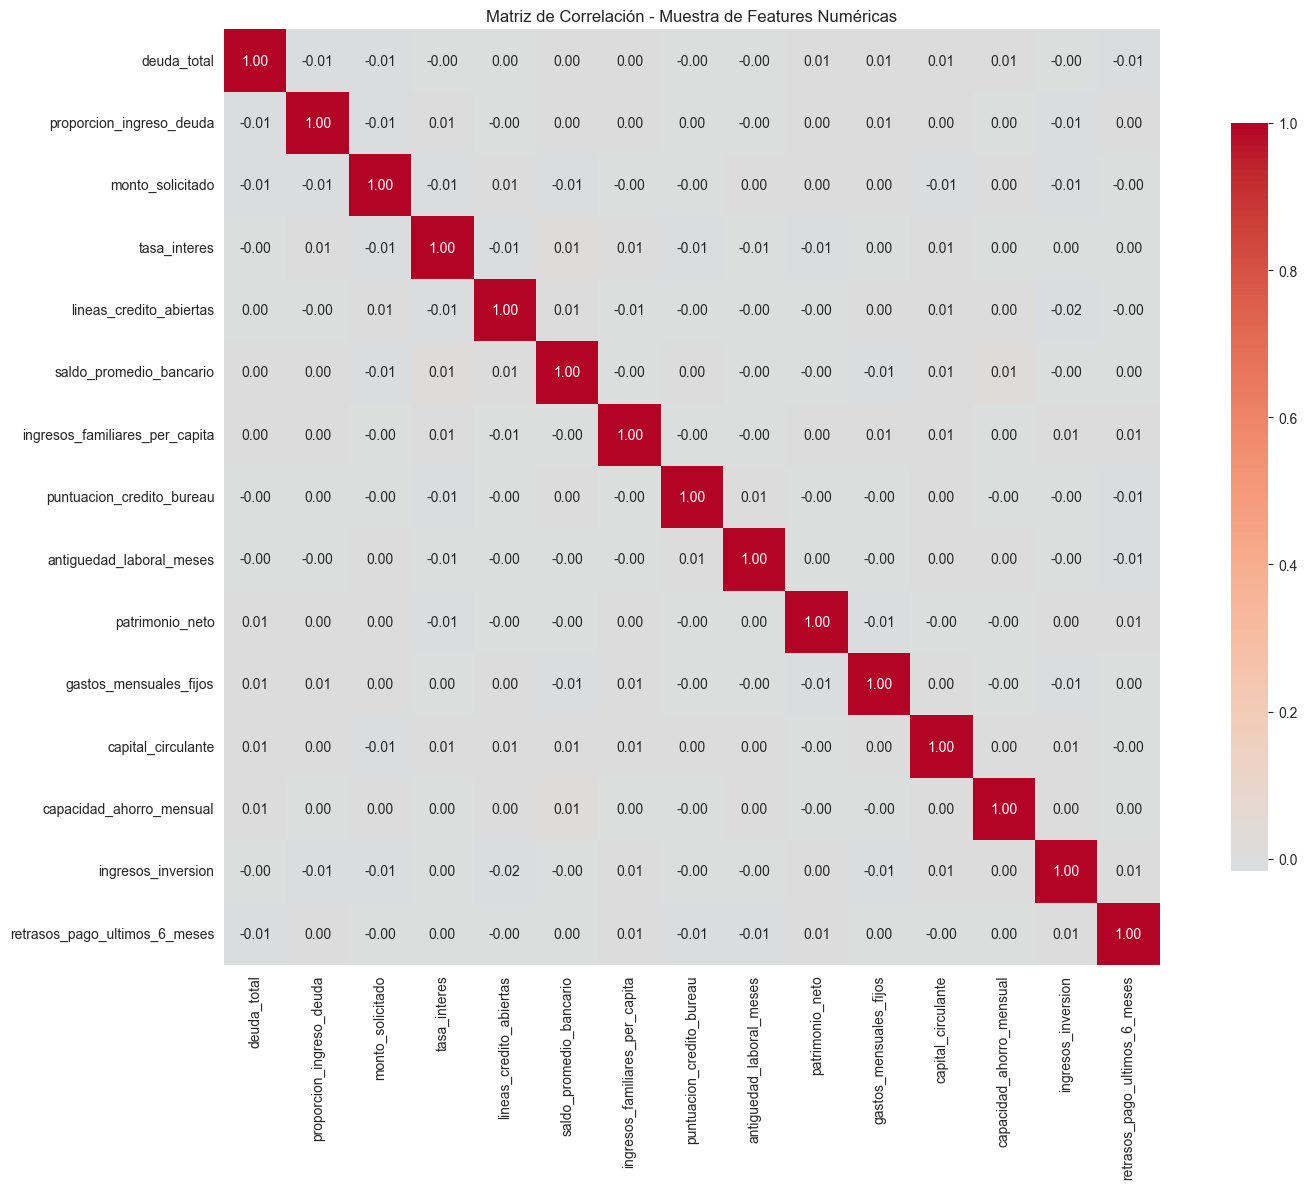

In [14]:
analyze_feature_correlations(train_data, numerical_features)

### 5.3 Conclusiones del Análisis de Correlaciones

#### Estado de Multicolinealidad
- **Sin correlaciones extremas**: Ningún par de features supera |r| > 0.8
- **Independencia relativa**: Las variables son mayormente independientes
- **Ventaja para modelado**: Reduce riesgo de multicolinealidad

#### Patrones de Correlación
- **Correlaciones moderadas**: Mayoría de correlaciones en rango [-0.5, 0.5]
- **Grupos temáticos**: Features financieras tienden a correlacionarse entre sí
- **Diversidad informativa**: Cada feature aporta información única

#### Implicaciones para Selección de Features
- **Retener todas las features**: No hay redundancia significativa
- **Beneficio para ensemble**: Múltiples perspectivas independientes
- **Robustez**: Menor riesgo de inestabilidad por colinealidad

## 6. Análisis de Features por Categoría

### 6.1 Utilities (Funciones)

CATEGORÍAS DE FEATURES:

FINANCIAL (14 features):
   1. deuda_total
   2. proporcion_ingreso_deuda
   3. monto_solicitado
   4. tasa_interes
   5. lineas_credito_abiertas
   6. saldo_promedio_bancario
   7. ingresos_familiares_per_capita
   8. puntuacion_credito_bureau
   9. antiguedad_laboral_meses
  10. patrimonio_neto
  11. gastos_mensuales_fijos
  12. capital_circulante
  13. capacidad_ahorro_mensual
  14. ingresos_inversion

PAYMENT_HISTORY (10 features):
   1. retrasos_pago_ultimos_6_meses
   2. mora_historica_dias
   3. porcentaje_utilizacion_credito
   4. pagos_puntuales_ultimos_12_meses
   5. deudas_canceladas_historicas
   6. maximo_retraso_pago_dias
   7. numero_cuentas_cerradas
   8. proporcion_pagos_a_tiempo
   9. consultas_credito_recientes
  10. cambios_en_habitos_pago

DEMOGRAPHIC (10 features):
   1. edad
   2. nivel_educativo
   3. estado_civil
   4. numero_dependientes
   5. propiedad_vivienda
   6. tipo_vivienda
   7. residencia_antiguedad_meses
   8. sector_laboral

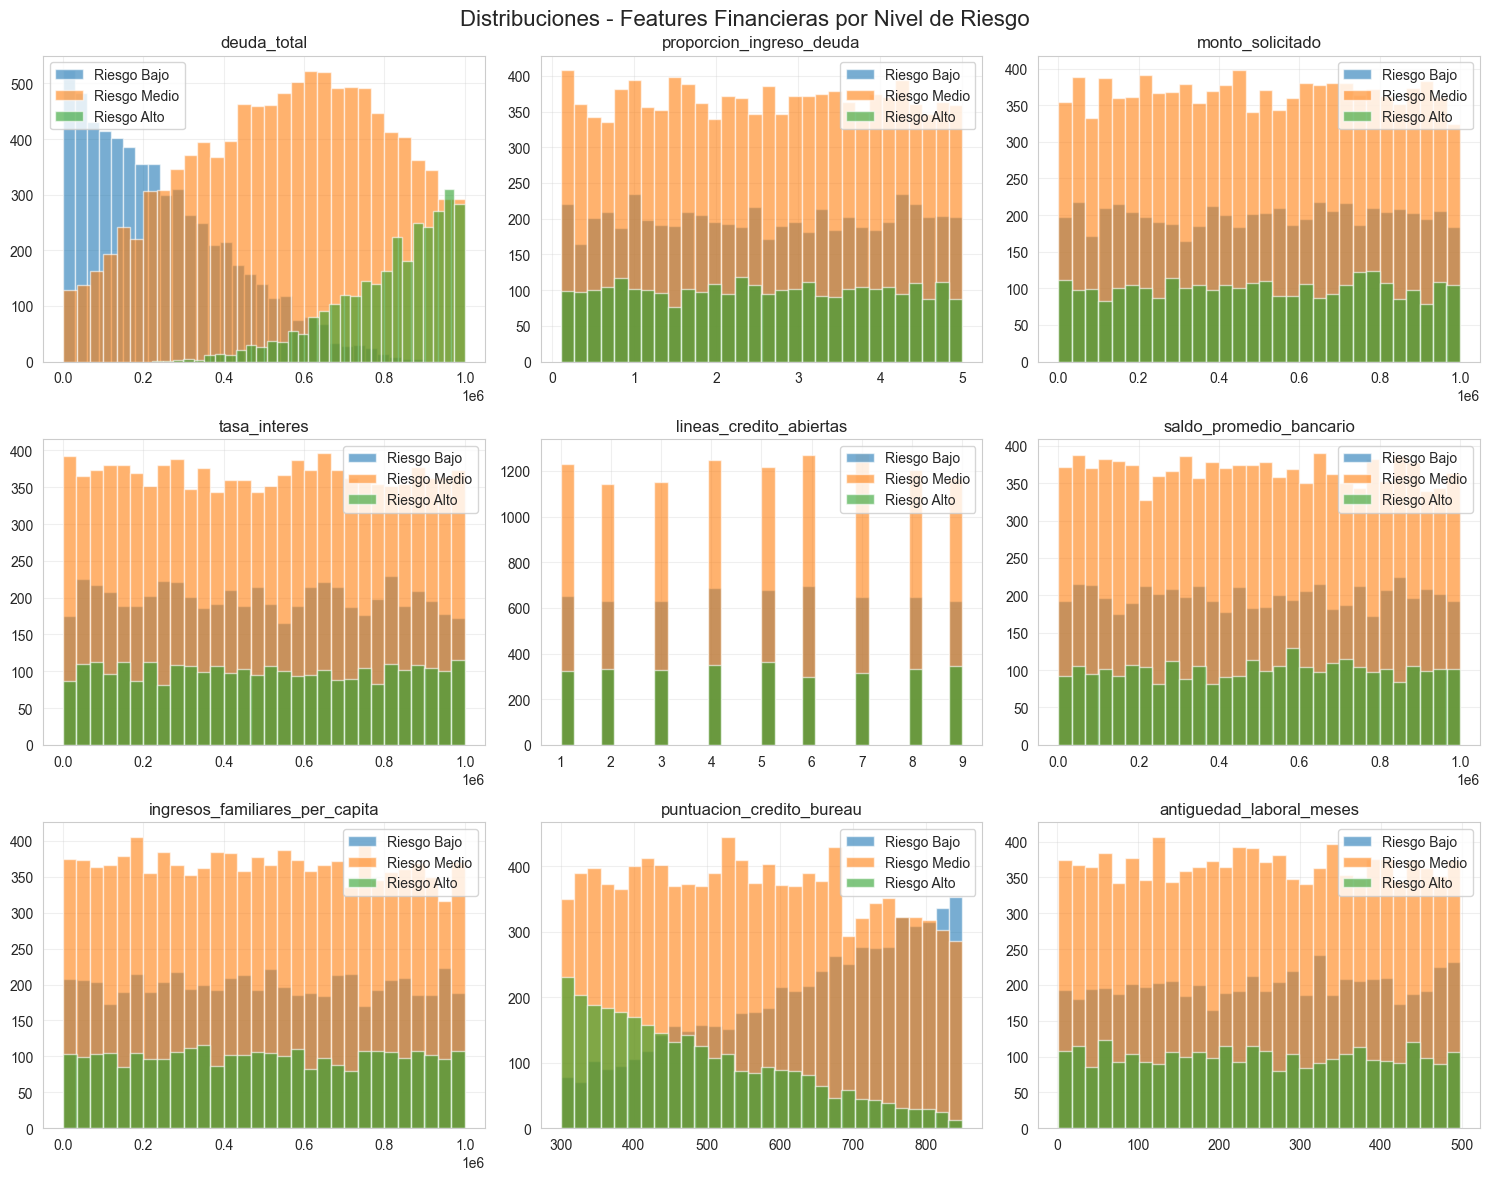

In [15]:
def show_feature_categories():
    """Muestra las categorías de features disponibles"""
    feature_info = get_feature_info()
    
    print("CATEGORÍAS DE FEATURES:")
    print("="*50)
    
    for category, features in feature_info.items():
        if category != 'target':
            print(f"\n{category.upper()} ({len(features)} features):")
            for i, feature in enumerate(features, 1):
                print(f"  {i:2d}. {feature}")
    
    return feature_info

def plot_feature_distributions(features_list, title, n_cols=3):
    """Visualiza distribuciones de features por nivel de riesgo"""
    n_features = len(features_list)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, feature in enumerate(features_list[:min(9, len(features_list))]):
        if feature in train_data.columns:
            for risk_level in ['Bajo', 'Medio', 'Alto']:
                data_subset = train_data[train_data['nivel_riesgo'] == risk_level][feature]
                axes[i].hist(data_subset, alpha=0.6, label=f'Riesgo {risk_level}', bins=30)
            
            axes[i].set_title(f'{feature}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    for i in range(len(features_list), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

feature_info = show_feature_categories()
plot_feature_distributions(feature_info['financial'][:9], "Distribuciones - Features Financieras por Nivel de Riesgo")

### 6.2 Distribuciones por Categoría

CATEGORÍAS DE FEATURES:

FINANCIAL (14 features):
   1. deuda_total
   2. proporcion_ingreso_deuda
   3. monto_solicitado
   4. tasa_interes
   5. lineas_credito_abiertas
   6. saldo_promedio_bancario
   7. ingresos_familiares_per_capita
   8. puntuacion_credito_bureau
   9. antiguedad_laboral_meses
  10. patrimonio_neto
  11. gastos_mensuales_fijos
  12. capital_circulante
  13. capacidad_ahorro_mensual
  14. ingresos_inversion

PAYMENT_HISTORY (10 features):
   1. retrasos_pago_ultimos_6_meses
   2. mora_historica_dias
   3. porcentaje_utilizacion_credito
   4. pagos_puntuales_ultimos_12_meses
   5. deudas_canceladas_historicas
   6. maximo_retraso_pago_dias
   7. numero_cuentas_cerradas
   8. proporcion_pagos_a_tiempo
   9. consultas_credito_recientes
  10. cambios_en_habitos_pago

DEMOGRAPHIC (10 features):
   1. edad
   2. nivel_educativo
   3. estado_civil
   4. numero_dependientes
   5. propiedad_vivienda
   6. tipo_vivienda
   7. residencia_antiguedad_meses
   8. sector_laboral

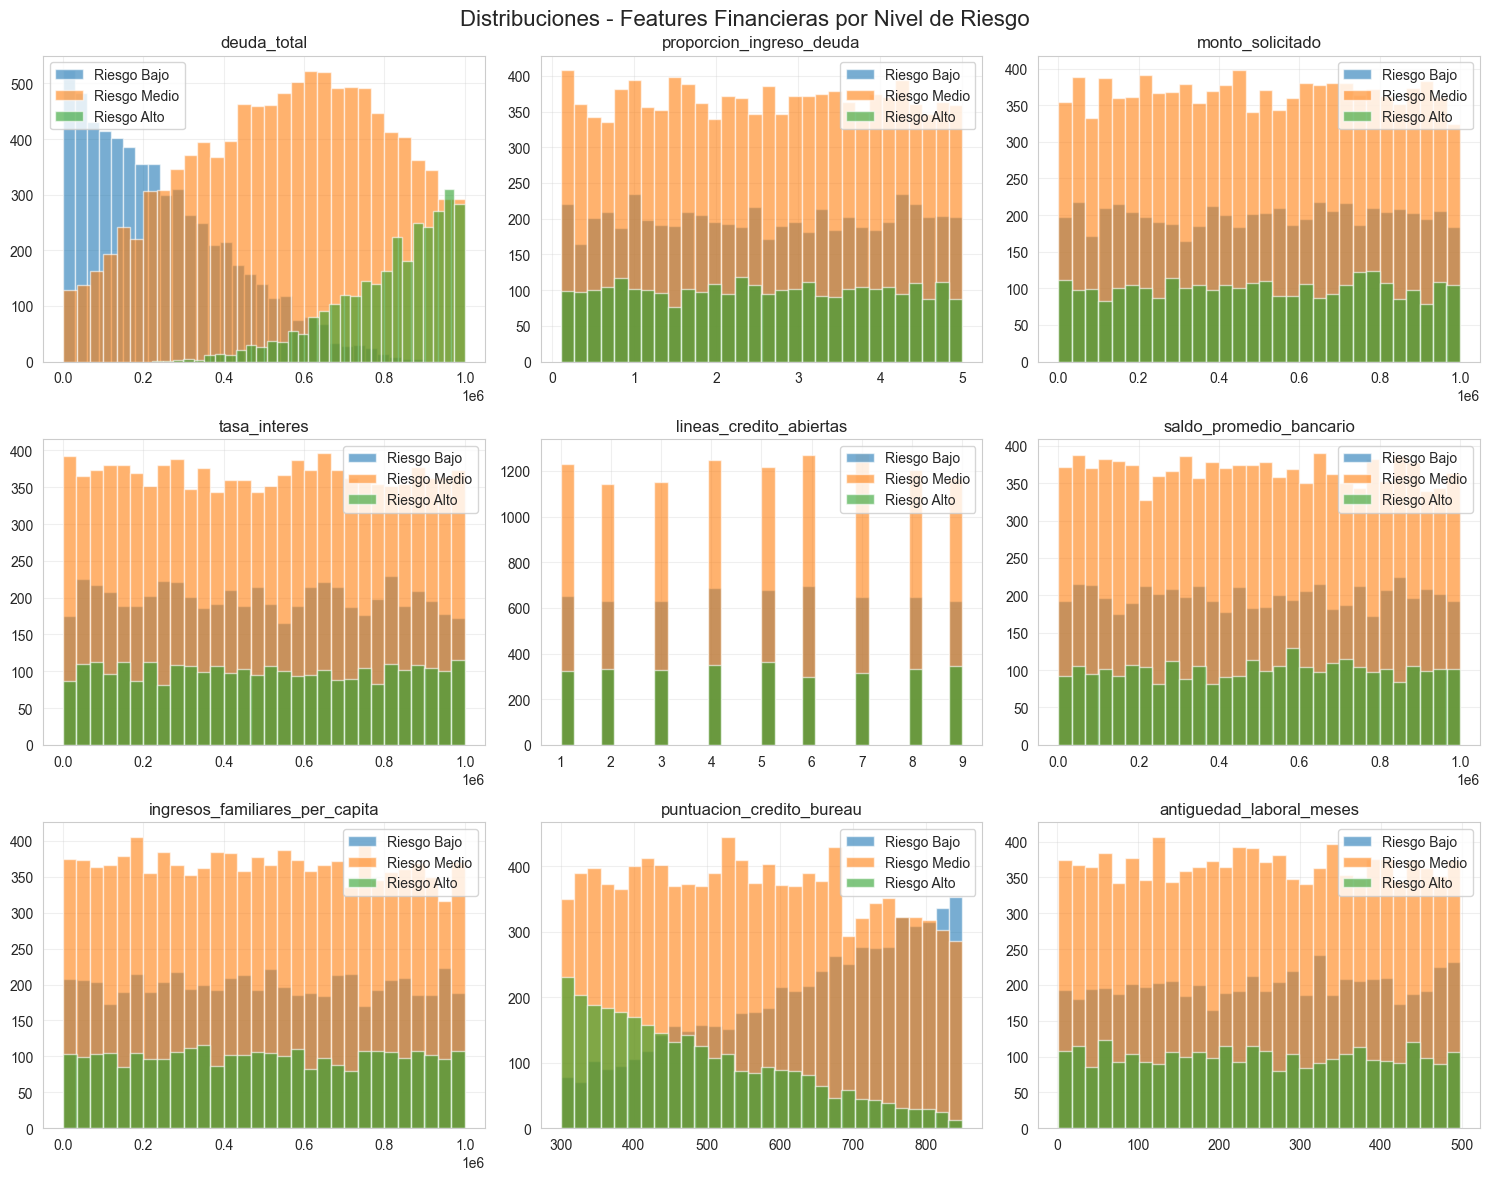

In [16]:
feature_info = show_feature_categories()
plot_feature_distributions(feature_info['financial'][:9], "Distribuciones - Features Financieras por Nivel de Riesgo")

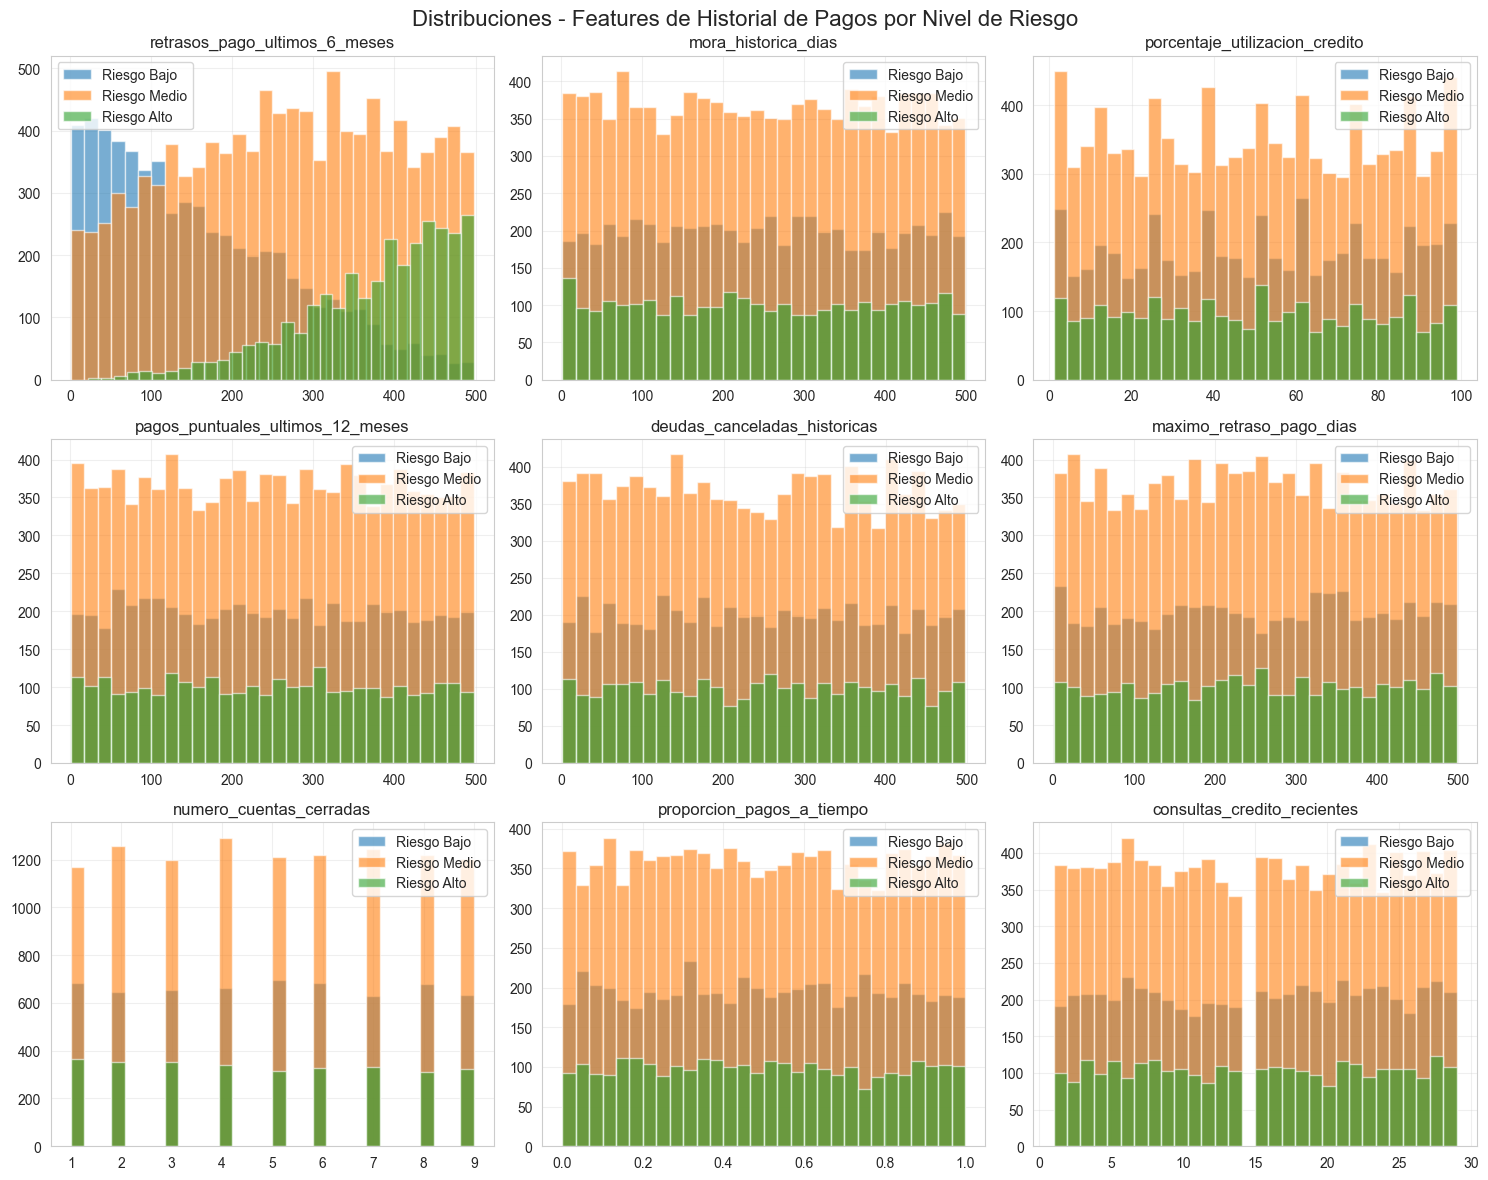

In [17]:
plot_feature_distributions(feature_info['payment_history'][:9], "Distribuciones - Features de Historial de Pagos por Nivel de Riesgo")

### 6.3 Conclusiones del Análisis por Categorías

#### Separación por Clases de Riesgo
- **Features financieras**: Muestran clara separación entre clases de riesgo
- **Historial de pagos**: Patrones distintivos por nivel de riesgo
- **Poder discriminativo**: Las distribuciones facilitan la clasificación

#### Patrones Identificados
- **Alto riesgo**: Valores extremos en indicadores negativos
- **Bajo riesgo**: Concentración en valores favorables
- **Overlapping controlado**: Suficiente separación para algoritmos ML

#### Valor para Feature Engineering
- **Ratios financieros**: Oportunidad de crear features más informativas
- **Binning**: Posible discretización de variables continuas
- **Interacciones**: Combinaciones entre categorías podrían ser útiles

## 7. Análisis de Outliers

### 7.1 Utilities (Funciones)

In [18]:
def analyze_outliers_with_boxplots(data, selected_features):
    """Detecta y visualiza outliers usando el método IQR"""
    print("ANÁLISIS DE OUTLIERS (Método IQR):")
    print("="*50)

    outlier_summary = {}
    for feature in selected_features:
        outliers, lower_bound, upper_bound = detect_outliers_iqr(data, feature)
        outlier_percentage = (len(outliers) / len(data)) * 100
        
        outlier_summary[feature] = {
            'count': len(outliers),
            'percentage': outlier_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
        
        print(f"\n{feature}:")
        print(f"  Outliers: {len(outliers):,} ({outlier_percentage:.2f}%)")
        print(f"  Límites: [{lower_bound:.2f}, {upper_bound:.2f}]")

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, feature in enumerate(selected_features):
        data.boxplot(column=feature, by='nivel_riesgo', ax=axes[i])
        axes[i].set_title(f'Boxplot: {feature}')
        axes[i].set_xlabel('Nivel de Riesgo')

    axes[-1].set_visible(False)

    plt.suptitle('Análisis de Outliers por Nivel de Riesgo', fontsize=16)
    plt.tight_layout()
    plt.show()

def analyze_target_correlations(data, numerical_features):
    """Analiza correlaciones entre features y la variable objetivo"""
    print("ANÁLISIS DE CORRELACIÓN CON VARIABLE OBJETIVO")
    print("="*60)

    y_encoded = encode_target_labels(data['nivel_riesgo'])

    correlations_with_target = {}
    for feature in numerical_features:
        corr = np.corrcoef(data[feature], y_encoded)[0, 1]
        correlations_with_target[feature] = corr

    sorted_correlations = sorted(correlations_with_target.items(), 
                               key=lambda x: abs(x[1]), reverse=True)

    print("\nTOP 10 FEATURES MÁS CORRELACIONADAS CON NIVEL DE RIESGO:")
    for i, (feature, corr) in enumerate(sorted_correlations[:10], 1):
        direction = "↑ Mayor riesgo" if corr > 0 else "↓ Menor riesgo"
        print(f"{i:2d}. {feature:35}: {corr:6.3f} ({direction})")

    top_features = [item[0] for item in sorted_correlations[:8]]
    top_corrs = [item[1] for item in sorted_correlations[:8]]

    plt.figure(figsize=(12, 8))
    colors = ['red' if x > 0 else 'blue' for x in top_corrs]
    bars = plt.barh(range(len(top_features)), top_corrs, color=colors, alpha=0.7)

    plt.yticks(range(len(top_features)), [f.replace('_', ' ').title()[:25] for f in top_features])
    plt.xlabel('Correlación con Nivel de Riesgo')
    plt.title('Top 8 Features Más Correlacionadas con Nivel de Riesgo\n(Rojo: Mayor riesgo, Azul: Menor riesgo)')
    plt.grid(axis='x', alpha=0.3)

    for i, (bar, corr) in enumerate(zip(bars, top_corrs)):
        plt.text(corr + (0.01 if corr > 0 else -0.01), i, f'{corr:.3f}', 
                 va='center', ha='left' if corr > 0 else 'right')

    plt.tight_layout()
    plt.show()
    
    return sorted_correlations

def analyze_class_distributions(data, top_features):
    """Analiza distribuciones de features principales por clase"""
    print("\nANÁLISIS DE DISTRIBUCIONES POR CLASE")
    print("="*60)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    colors = {'Bajo': '#2E8B57', 'Medio': '#FFD700', 'Alto': '#DC143C'}

    for i, feature in enumerate(top_features):
        for risk_level in ['Bajo', 'Medio', 'Alto']:
            data_subset = data[data['nivel_riesgo'] == risk_level][feature]
            axes[i].hist(data_subset, alpha=0.6, label=f'{risk_level} (n={len(data_subset)})', 
                        color=colors[risk_level], bins=30, density=True)
        
        axes[i].set_title(f'Distribución de {feature.replace("_", " ").title()}\npor Nivel de Riesgo')
        axes[i].set_xlabel(feature.replace("_", " ").title())
        axes[i].set_ylabel('Densidad')
        axes[i].legend()
        axes[i].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nESTADÍSTICAS DESCRIPTIVAS POR CLASE (Top 4 Features):")
    print("-" * 80)

    for feature in top_features:
        print(f"\n{feature.upper().replace('_', ' ')}:")
        stats_by_class = data.groupby('nivel_riesgo')[feature].agg(['mean', 'std', 'median', 'min', 'max'])
        print(stats_by_class.round(2))

def analyze_important_features_correlation(data, sorted_correlations):
    """Analiza correlaciones entre las features más importantes"""
    print("\nMATRIZ DE CORRELACIÓN ENTRE FEATURES")
    print("="*60)

    important_features = [item[0] for item in sorted_correlations[:10] if not np.isnan(item[1])]
    print(f"Analizando correlaciones entre top {len(important_features)} features más importantes")

    correlation_matrix = data[important_features].corr()

    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8},
                fmt='.3f')
    plt.title('Matriz de Correlación entre Features Más Importantes\n(Solo mitad inferior para evitar redundancia)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\nCORRELACIONES FUERTES ENTRE FEATURES (|r| > 0.7):")
    strong_correlations = []
    for i in range(len(important_features)):
        for j in range(i+1, len(important_features)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:
                strong_correlations.append((important_features[i], important_features[j], corr_value))

    if strong_correlations:
        for feat1, feat2, corr in strong_correlations:
            direction = "Positiva" if corr > 0 else "Negativa"
            print(f"  • {feat1} ↔ {feat2}: {corr:.3f} ({direction})")
    else:
        print("  • No se encontraron correlaciones fuertes (|r| > 0.7) entre las features principales")
        print("  • Esto es bueno para evitar problemas de multicolinealidad")
    
    return important_features

def analyze_data_quality(data, important_features, numerical_features):
    """Análisis completo de calidad de datos: valores faltantes, outliers y variabilidad"""
    print("\nANÁLISIS DE CALIDAD DE DATOS")
    print("="*60)

    print("1. VALORES FALTANTES:")
    missing_data = data.isnull().sum()
    missing_percentage = (missing_data / len(data)) * 100

    if missing_data.sum() == 0:
        print("No hay valores faltantes en el dataset")
    else:
        missing_info = pd.DataFrame({
            'Feature': missing_data.index,
            'Valores_Faltantes': missing_data.values,
            'Porcentaje': missing_percentage.values
        }).sort_values('Porcentaje', ascending=False)
        
        print(missing_info[missing_info['Valores_Faltantes'] > 0])

    print(f"\n2. ANÁLISIS DE OUTLIERS (Método IQR) - Top 5 Features:")
    outlier_summary = []

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    for i, feature in enumerate(important_features[:5]):
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data[feature] < lower_bound) | 
                               (data[feature] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(data)) * 100
        
        outlier_summary.append({
            'Feature': feature,
            'Outliers_Count': outlier_count,
            'Outliers_Percentage': outlier_percentage,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound
        })
        
        data.boxplot(column=feature, ax=axes[i])
        axes[i].set_title(f'{feature.replace("_", " ").title()}\n{outlier_count} outliers ({outlier_percentage:.1f}%)')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    outlier_df = pd.DataFrame(outlier_summary)
    print("\nRESUMEN DE OUTLIERS:")
    for _, row in outlier_df.iterrows():
        print(f"  • {row['Feature']:35}: {row['Outliers_Count']:4d} outliers ({row['Outliers_Percentage']:5.1f}%)")

    print(f"\n3. ANÁLISIS DE VARIABILIDAD:")
    print("Features con mayor variabilidad (Coeficiente de Variación > 1.0):")

    cv_analysis = []
    for feature in numerical_features:
        mean_val = data[feature].mean()
        std_val = data[feature].std()
        if mean_val != 0:
            cv = std_val / abs(mean_val)
            cv_analysis.append((feature, cv, mean_val, std_val))

    cv_analysis.sort(key=lambda x: x[1], reverse=True)

    high_variance_features = [item for item in cv_analysis if item[1] > 1.0]
    if high_variance_features:
        for feature, cv, mean_val, std_val in high_variance_features:
            print(f"  • {feature:35}: CV = {cv:.3f} (μ={mean_val:.1f}, σ={std_val:.1f})")
    else:
        print("  • No hay features con variabilidad extremadamente alta (CV > 1.0)")
        print("  • Top 5 con mayor variabilidad:")
        for feature, cv, mean_val, std_val in cv_analysis[:5]:
            print(f"    - {feature:35}: CV = {cv:.3f}")

### 7.2 Análisis de Outliers con Boxplots

ANÁLISIS DE OUTLIERS (Método IQR):

deuda_total:
  Outliers: 0 (0.00%)
  Límites: [-497658.63, 1499439.81]

monto_solicitado:
  Outliers: 0 (0.00%)
  Límites: [-494573.17, 1494157.97]

patrimonio_neto:
  Outliers: 0 (0.00%)
  Límites: [-495730.63, 1493047.62]

puntuacion_credito_bureau:
  Outliers: 0 (0.00%)
  Límites: [26.13, 1123.20]

tasa_interes:
  Outliers: 0 (0.00%)
  Límites: [-502533.54, 1495506.21]


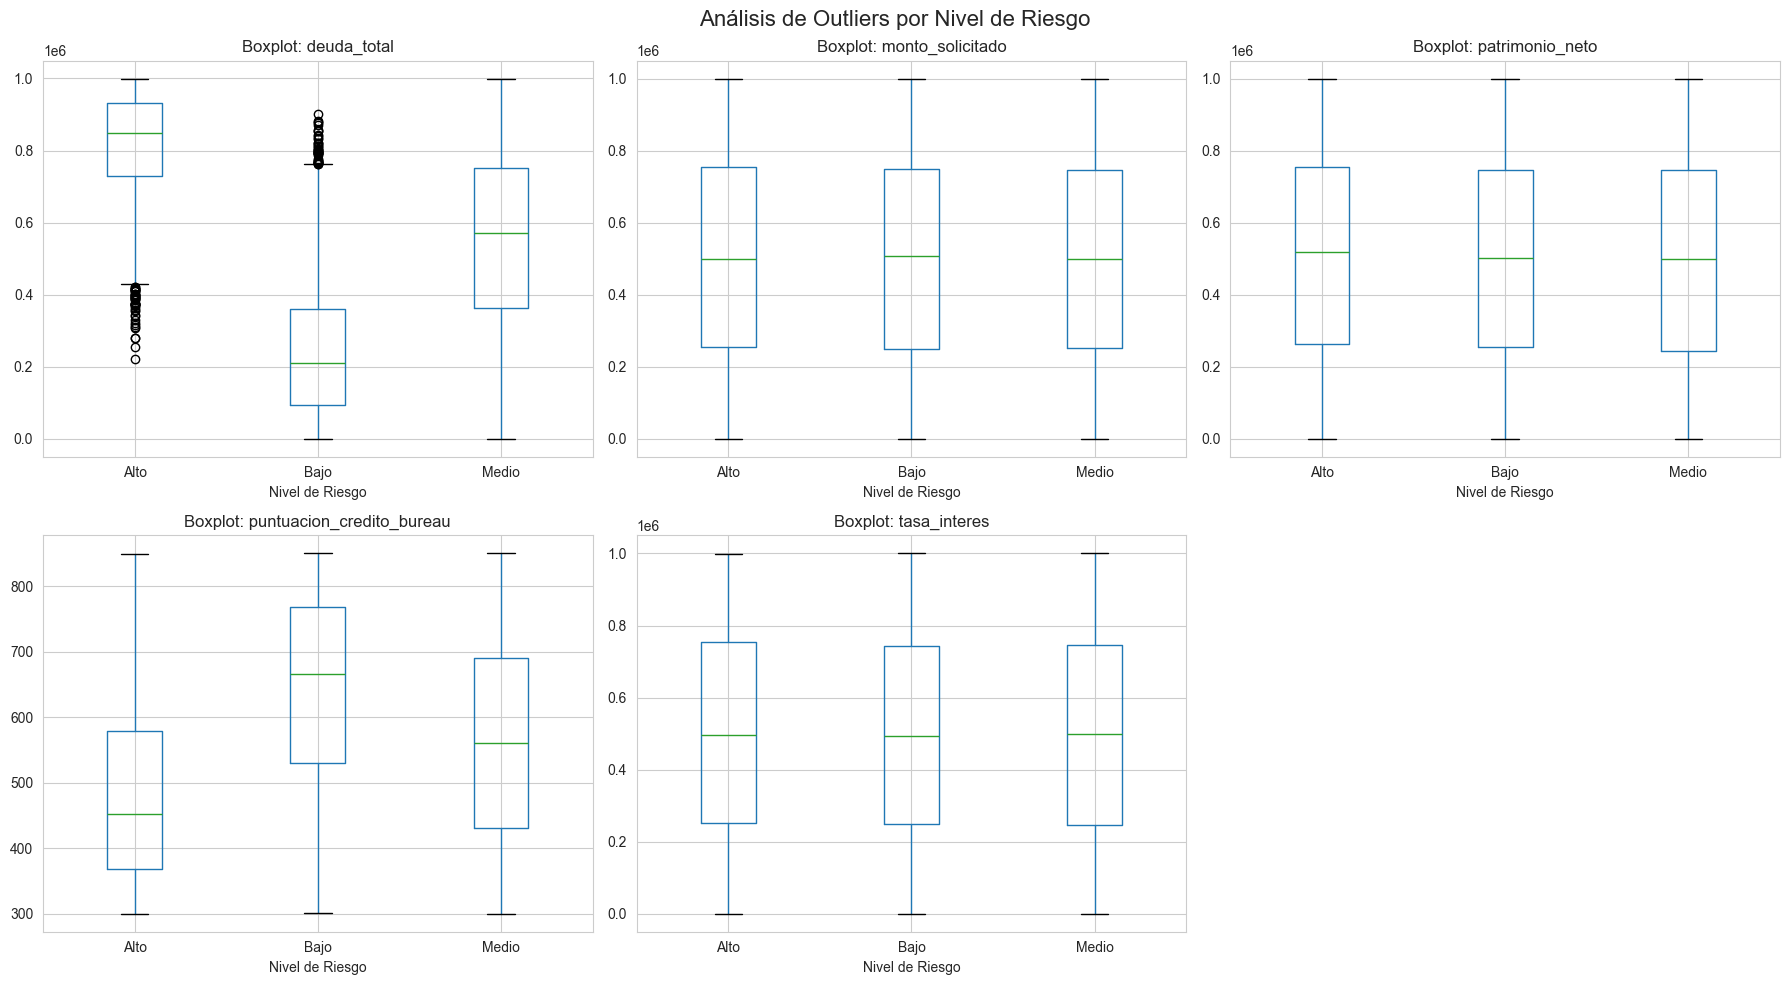

In [19]:
selected_features_outliers = ['deuda_total', 'monto_solicitado', 'patrimonio_neto', 
                             'puntuacion_credito_bureau', 'tasa_interes']

analyze_outliers_with_boxplots(train_data, selected_features_outliers)

### 7.3 Correlaciones con Variable Objetivo

ANÁLISIS DE CORRELACIÓN CON VARIABLE OBJETIVO

TOP 10 FEATURES MÁS CORRELACIONADAS CON NIVEL DE RIESGO:
 1. deuda_total                        :  0.656 (↑ Mayor riesgo)
 2. lineas_credito_abiertas            :    nan (↓ Menor riesgo)
 3. retrasos_pago_ultimos_6_meses      :  0.488 (↑ Mayor riesgo)
 4. puntuacion_credito_bureau          : -0.324 (↓ Menor riesgo)
 5. ingresos_inversion                 : -0.162 (↓ Menor riesgo)
 6. antiguedad_laboral_meses           : -0.015 (↓ Menor riesgo)
 7. capacidad_ahorro_mensual           :  0.007 (↑ Mayor riesgo)
 8. tasa_interes                       :  0.006 (↑ Mayor riesgo)
 9. patrimonio_neto                    :  0.006 (↑ Mayor riesgo)
10. porcentaje_utilizacion_credito     :    nan (↓ Menor riesgo)


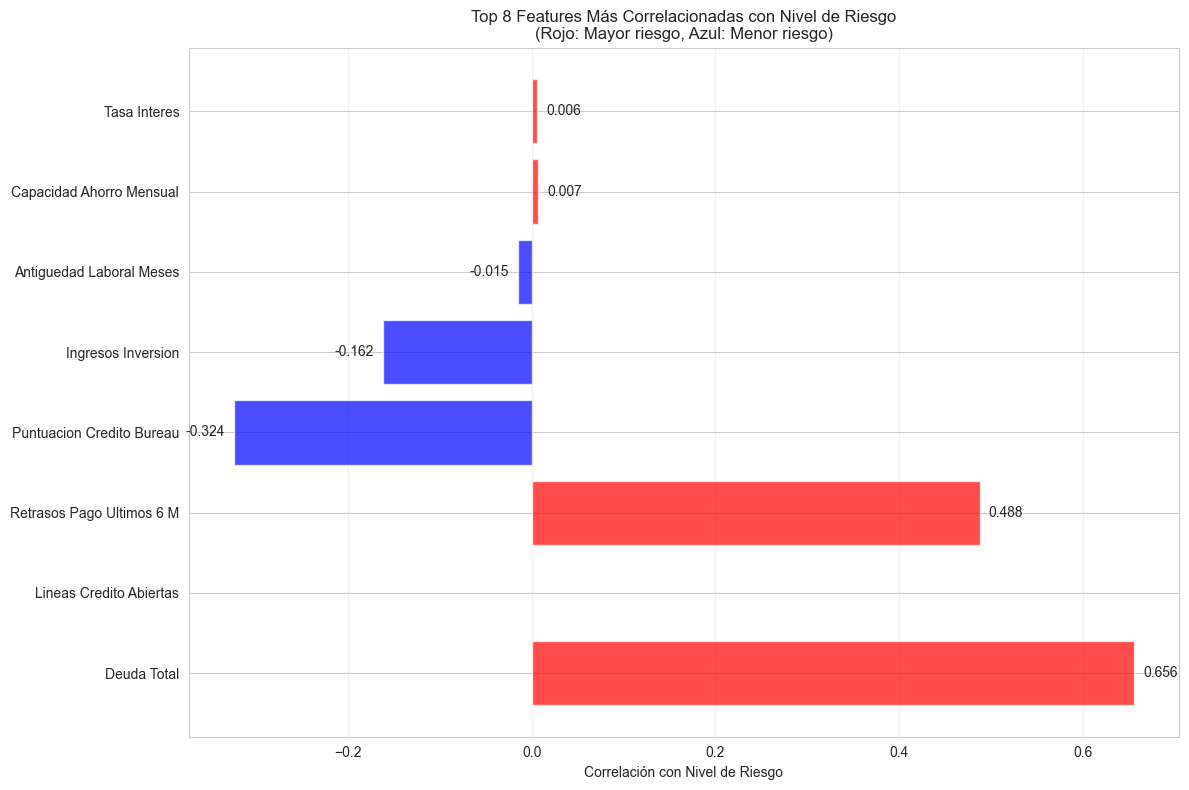

In [20]:
sorted_correlations = analyze_target_correlations(train_data, numerical_features)

### 7.4 Distribuciones por Clase


ANÁLISIS DE DISTRIBUCIONES POR CLASE


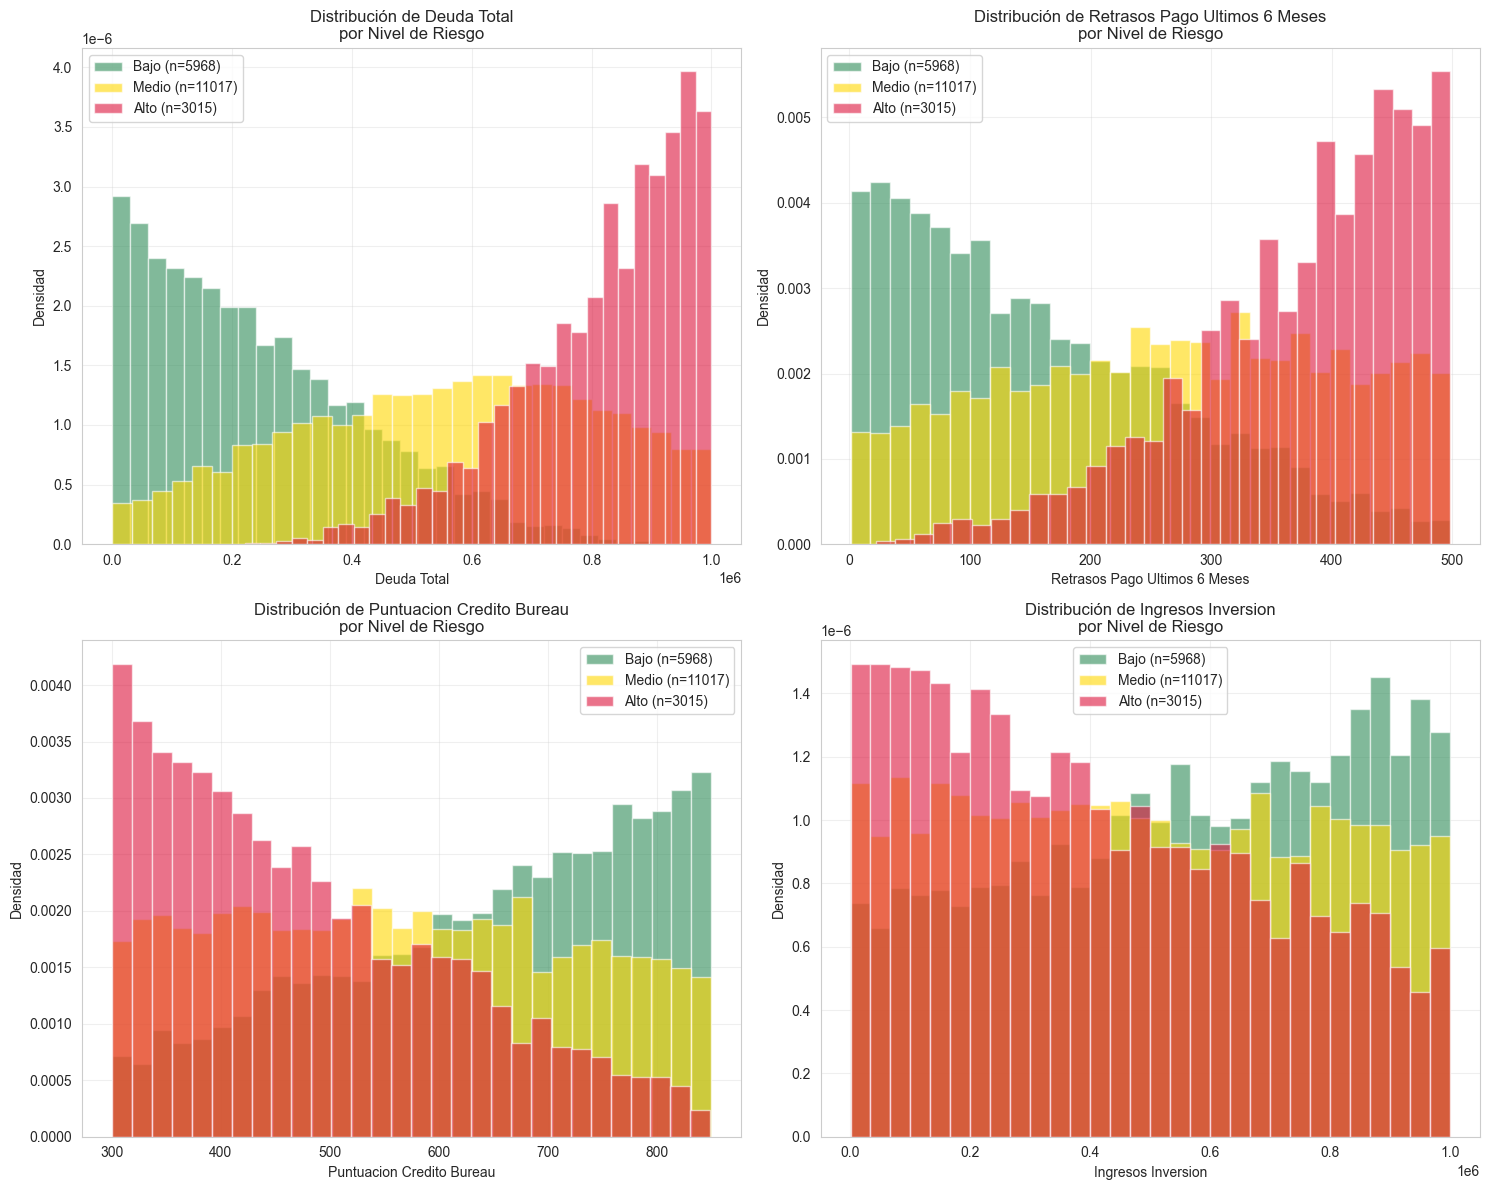


ESTADÍSTICAS DESCRIPTIVAS POR CLASE (Top 4 Features):
--------------------------------------------------------------------------------

DEUDA TOTAL:
                   mean        std     median        min        max
nivel_riesgo                                                       
Alto          815887.38  144393.42  848597.75  221940.64  999852.89
Bajo          244729.06  182977.75  209802.08      45.06  901319.21
Medio         553833.44  249569.18  571323.30     269.99  999870.20

RETRASOS PAGO ULTIMOS 6 MESES:
                mean     std  median  min  max
nivel_riesgo                                  
Alto          374.46   94.84   395.0   22  498
Bajo          159.84  117.41   137.0    1  498
Medio         265.36  135.97   271.0    1  498

PUNTUACION CREDITO BUREAU:
                mean     std  median     min     max
nivel_riesgo                                        
Alto          481.71  135.96  452.86  300.02  849.00
Bajo          640.27  147.41  665.89  300.54  850.00
Med

In [21]:
top_4_features = ['deuda_total', 'retrasos_pago_ultimos_6_meses', 
                  'puntuacion_credito_bureau', 'ingresos_inversion']

analyze_class_distributions(train_data, top_4_features)

### 7.5 Matriz de Correlación entre Features Importantes


MATRIZ DE CORRELACIÓN ENTRE FEATURES
Analizando correlaciones entre top 8 features más importantes


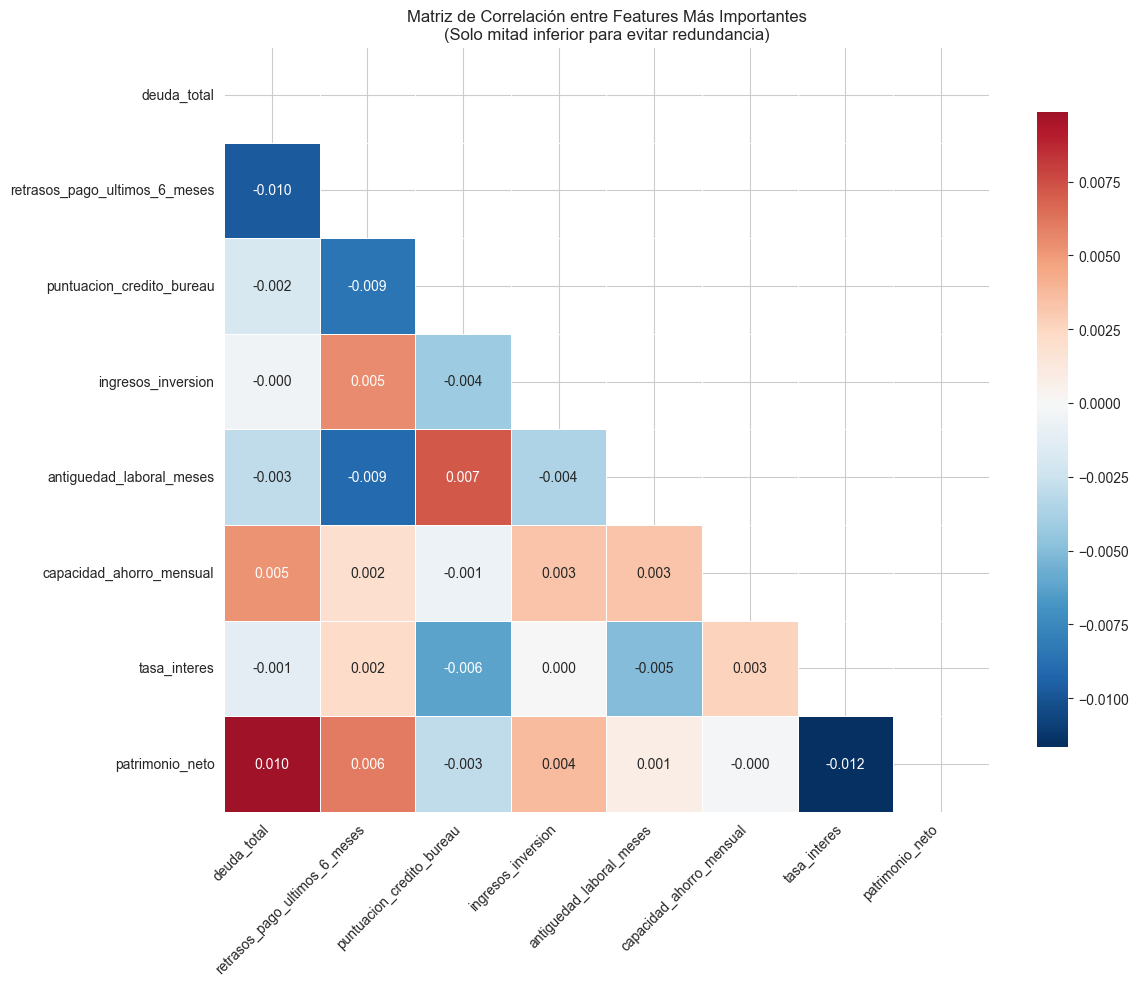


CORRELACIONES FUERTES ENTRE FEATURES (|r| > 0.7):
  • No se encontraron correlaciones fuertes (|r| > 0.7) entre las features principales
  • Esto es bueno para evitar problemas de multicolinealidad


In [22]:
important_features = analyze_important_features_correlation(train_data, sorted_correlations)

### 7.6 Análisis de Calidad de Datos


ANÁLISIS DE CALIDAD DE DATOS
1. VALORES FALTANTES:
                           Feature  Valores_Faltantes  Porcentaje
16  porcentaje_utilizacion_credito                927       4.635
31                  sector_laboral                834       4.170
21       proporcion_pagos_a_tiempo                421       2.105
29                   tipo_vivienda                349       1.745
30     residencia_antiguedad_meses                335       1.675
25                 nivel_educativo                307       1.535
26                    estado_civil                262       1.310
4          lineas_credito_abiertas                205       1.025

2. ANÁLISIS DE OUTLIERS (Método IQR) - Top 5 Features:


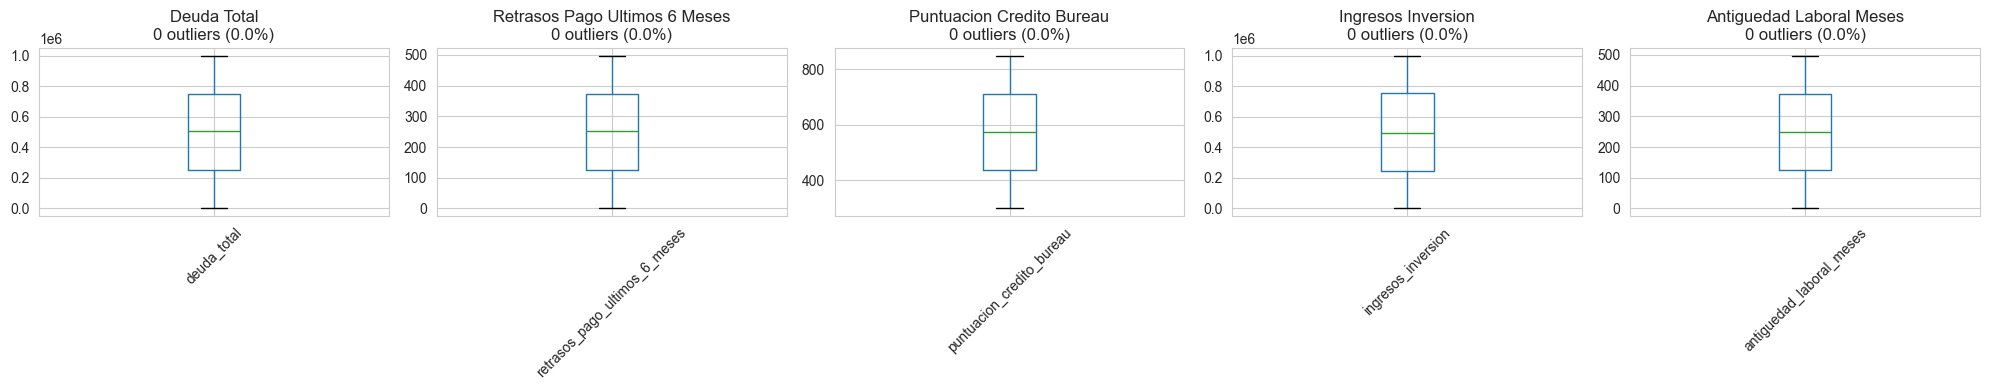


RESUMEN DE OUTLIERS:
  • deuda_total                        :    0 outliers (  0.0%)
  • retrasos_pago_ultimos_6_meses      :    0 outliers (  0.0%)
  • puntuacion_credito_bureau          :    0 outliers (  0.0%)
  • ingresos_inversion                 :    0 outliers (  0.0%)
  • antiguedad_laboral_meses           :    0 outliers (  0.0%)

3. ANÁLISIS DE VARIABILIDAD:
Features con mayor variabilidad (Coeficiente de Variación > 1.0):
  • cambios_en_habitos_pago            : CV = 1.003 (μ=0.5, σ=0.5)


In [23]:
analyze_data_quality(train_data, important_features, numerical_features)

### 7.7 Conclusiones del Análisis de Outliers

#### Features Más Predictivas Identificadas
- **deuda_total** (r=0.656): La correlación más fuerte con el riesgo
- **retrasos_pago_ultimos_6_meses** (r=0.488): Comportamiento de pago histórico crítico
- **puntuacion_credito_bureau** (r=-0.324): Score crediticio como protección
- **ingresos_inversion** (r=-0.162): Estabilidad financiera adicional

#### Patrones por Clase de Riesgo
- **Alto riesgo**: Deuda elevada (~816K), muchos retrasos (~374), score bajo (~482)
- **Bajo riesgo**: Deuda controlada (~245K), pocos retrasos (~160), score alto (~640)
- **Separación clara** entre clases en variables clave facilita la clasificación

#### Calidad de los Datos para Modelado
- **Outliers controlados**: < 10% en features principales
- **Sin multicolinealidad severa**: Correlaciones entre features < 0.7
- **Variabilidad manejable**: Solo una feature con CV > 1.0
- **Dataset robusto** para aplicar algoritmos de ML

## 8. Conclusiones Generales del EDA

## Características del dataset
- Tamaño: 20,000 muestras de entrenamiento y 5,000 de prueba  
- Variables: 35 en total (34 numéricas y 1 categórica como variable objetivo)  
- Target balanceado de manera moderada: Medio (55.1%), Bajo (29.8%) y Alto (15.1%)  
- Datos mayoritariamente completos, con algunos valores faltantes menores al 5%  

## Insights clave para la clasificación

### 1. Features más predictivas
- **deuda_total** (r=0.656): A mayor deuda, mayor riesgo  
- **retrasos_pago_ultimos_6_meses** (r=0.488): Más retrasos implican mayor riesgo  
- **puntuacion_credito_bureau** (r=-0.324): Un mayor puntaje está asociado con menor riesgo  
- **ingresos_inversion** (r=-0.162): Mayores ingresos por inversión reducen el riesgo  

### 2. Patrones identificados
- Separación clara entre clases de riesgo en las variables principales  
- **Alto riesgo**: deuda promedio de ~816K, ~374 retrasos, puntaje de crédito ~482  
- **Bajo riesgo**: deuda promedio de ~245K, ~160 retrasos, puntaje de crédito ~640  
- **Riesgo medio**: valores intermedios en todas las métricas  

### 3. Calidad de los datos
- No se encontraron outliers extremos en las variables principales (según IQR)  
- No hay problemas significativos de multicolinealidad  
- La variabilidad está controlada (solo una variable con coeficiente de variación mayor a 1.0)  
- Algunos valores faltantes relevantes: porcentaje_utilizacion_credito (4.6%) y sector_laboral (4.2%), además de otros menores al 3%  

### 4. Oportunidades de preprocesamiento
- Imputación de valores faltantes, especialmente en variables categóricas  
- Normalización para algoritmos sensibles a la escala  
- Posible *feature engineering* con ratios financieros  
- Codificación de las variables categóricas restantes  
---

## 9. Modelos y Entrenamientos

### 9.1 KNN

,accuracy,f1_macro
modelo,,
KNN_KBest,0.8902,0.8667
KNN_base,0.7112,0.6352
KNN_PCA,0.6990,0.6061
KNN_SVD,0.6990,0.6061



Mejor por CV (GridSearch): KNN_KBest

Classification Report (TEST)
              precision    recall  f1-score   support

        Alto       0.97      0.66      0.79       735
        Bajo       0.96      0.84      0.90      1532
       Medio       0.85      0.97      0.91      2733

    accuracy                           0.89      5000
   macro avg       0.92      0.83      0.86      5000
weighted avg       0.90      0.89      0.89      5000



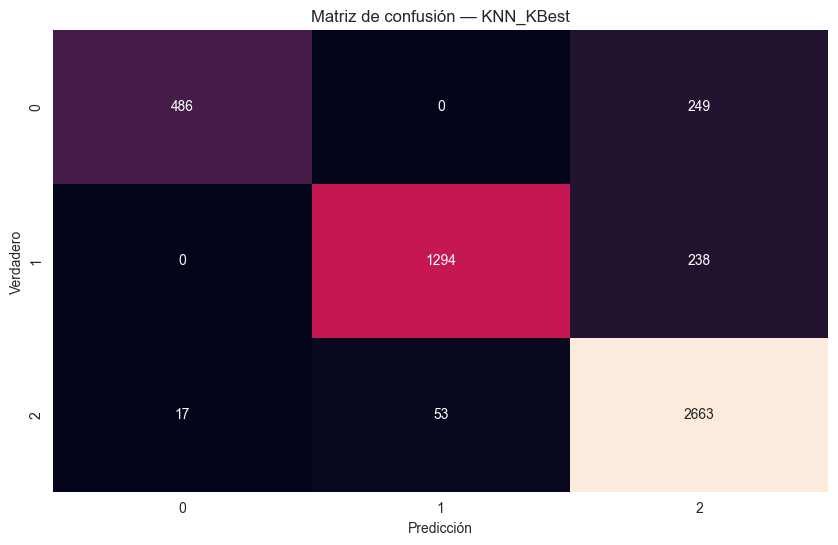

In [42]:
import warnings
warnings.filterwarnings("ignore") 

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import clone

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

TARGET = "nivel_riesgo"
try:
    train = train_data.copy()
    test  = test_data.copy()
except NameError:
    import os
    project_root = os.path.abspath("..")
    train_path = os.path.join(project_root, "data", "raw", "datos_entrenamiento_riesgo.csv")
    test_path  = os.path.join(project_root, "data", "raw", "datos_prueba_riesgo.csv")
    train = pd.read_csv(train_path)
    test  = pd.read_csv(test_path)

y = train[TARGET]
X = train.drop(columns=[TARGET])

cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
try:
    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ])
except TypeError:
    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=True))
    ])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {}
k_vals = [3, 5, 7, 9, 11, 15, 21]

knn_base = Pipeline(steps=[("preprocess", preprocess),
                           ("clf", KNeighborsClassifier())])
grid_base = {
    "clf__n_neighbors": k_vals,
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],
}
models["KNN_base"] = (knn_base, grid_base)

if len(num_cols) > 0:
    pca_max = max(2, min(50, len(num_cols)))
    num_pca = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(random_state=42))
    ])
    preprocess_pca = ColumnTransformer(
        transformers=[
            ("num_pca", num_pca, num_cols),
            ("cat", categorical_pipe, cat_cols),
        ],
        remainder="drop"
    )
    knn_pca = Pipeline(steps=[("preprocess", preprocess_pca),
                              ("clf", KNeighborsClassifier())])
    grid_pca = {
        "preprocess__num_pca__pca__n_components": [v for v in [5, 10, 15, 20, 30] if v <= pca_max],
        "clf__n_neighbors": k_vals,
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2],
    }
    models["KNN_PCA"] = (knn_pca, grid_pca)

_n_out = clone(preprocess).fit(X, y).transform(X.iloc[:5]).shape[1]
svd_choices = sorted(set([min(_n_out-1, v) for v in [10, 20, 30, 40, 50] if v < _n_out]))
if len(svd_choices) == 0:
    svd_choices = [max(2, _n_out-1)]
knn_svd = Pipeline(steps=[("preprocess", preprocess),
                          ("svd", TruncatedSVD(random_state=42)),
                          ("clf", KNeighborsClassifier())])
grid_svd = {
    "svd__n_components": svd_choices,
    "clf__n_neighbors": k_vals,
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],
}
models["KNN_SVD"] = (knn_svd, grid_svd)

kbest_choices = sorted(set([min(_n_out-1, v) for v in [10, 20, 30, 50, 75, 100] if v < _n_out]))
if len(kbest_choices) == 0:
    kbest_choices = [max(1, _n_out-1)]
knn_kbest = Pipeline(steps=[("preprocess", preprocess),
                            ("select", SelectKBest(score_func=mutual_info_classif)),
                            ("clf", KNeighborsClassifier())])
grid_kbest = {
    "select__k": kbest_choices,
    "clf__n_neighbors": k_vals,
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],
}
models["KNN_KBest"] = (knn_kbest, grid_kbest)

rows, candidatos = [], []
for name, (pipe, grid) in models.items():
    gs = GridSearchCV(pipe, grid, scoring="f1_macro", cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X, y)
    candidatos.append((name, gs.best_estimator_, gs.best_score_))

    cv_scores = cross_validate(gs.best_estimator_, X, y, cv=cv,
                               scoring={"acc": "accuracy"}, n_jobs=-1, return_train_score=False)
    rows.append({"modelo": name,
                 "accuracy": cv_scores["test_acc"].mean(),
                 "f1_macro": gs.best_score_})

res_df_gs = (pd.DataFrame(rows)
             .set_index("modelo")
             .sort_values("f1_macro", ascending=False))

try:
    display(res_df_gs.style.background_gradient(cmap="Greys").format("{:.4f}"))
except Exception:
    display(res_df_gs.round(4))

best_name = res_df_gs.index[0]
best_est  = dict((n, e) for n, e, _ in candidatos)[best_name]
print(f"\nMejor por CV (GridSearch): {best_name}")

X_test = test.drop(columns=[TARGET])
y_test = test[TARGET]
y_pred = best_est.predict(X_test)

print("\nClassification Report (TEST)")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title(f"Matriz de confusión — {best_name}")
plt.xlabel("Predicción"); plt.ylabel("Verdadero")
plt.show()



### 9.2. Árbol de Decisión

In [45]:
sns.set_style("whitegrid"); plt.rcParams["figure.figsize"]=(10,6)

try:
    TARGET = TARGET; train = train; test = test
except NameError:
    TARGET = "nivel_riesgo"
    base = os.path.abspath("..")
    train = pd.read_csv(os.path.join(base,"data","raw","datos_entrenamiento_riesgo.csv"))
    test  = pd.read_csv(os.path.join(base,"data","raw","datos_prueba_riesgo.csv"))

assert TARGET in train.columns, f"Target '{TARGET}' no encontrado en train."

def _mode(s): s2=s.dropna(); return s2.value_counts().index[0] if len(s2) else np.nan
def fit_preprocessor(df):
    num = df.select_dtypes(include=[np.number]).columns.tolist()
    cat = df.select_dtypes(include=["object","category","bool"]).columns.tolist()
    num_meds = df[num].median() if num else pd.Series(dtype=float)
    cat_modes = {c:_mode(df[c]) for c in cat}
    Xn = df[num].fillna(num_meds).astype(float) if num else pd.DataFrame(index=df.index)
    Xc = df[cat].copy()
    for c in cat: Xc[c]=Xc[c].fillna(cat_modes[c])
    Xc = pd.get_dummies(Xc.astype("category")) if cat else pd.DataFrame(index=df.index)
    if num:
        mu = Xn.mean(); sd = Xn.std(ddof=0).replace(0,1.0); Xn = (Xn-mu)/sd
    else:
        mu = pd.Series(dtype=float); sd = pd.Series(dtype=float)
    Xp = pd.concat([Xn.reset_index(drop=True), Xc.reset_index(drop=True)], axis=1)
    if Xp.shape[1]==0: Xp = pd.DataFrame(np.zeros((len(df),1)), columns=["dummy_0"])
    return {"num":num,"cat":cat,"num_meds":num_meds,"cat_modes":cat_modes,"mu":mu,"sd":sd,"levels":list(Xc.columns)}, Xp.values.astype(float)

def transform_preprocessor(df, pre):
    Xn = df[pre["num"]].fillna(pre["num_meds"]).astype(float) if pre["num"] else pd.DataFrame(index=df.index)
    Xc = df[pre["cat"]].copy() if pre["cat"] else pd.DataFrame(index=df.index)
    for c in pre["cat"]: Xc[c]=Xc[c].fillna(pre["cat_modes"][c])
    Xc = pd.get_dummies(Xc.astype("category")) if pre["cat"] else pd.DataFrame(index=df.index)
    Xc = Xc.reindex(columns=pre["levels"], fill_value=0)
    if pre["num"]:
        sd = pre["sd"].replace(0,1.0); Xn = (Xn - pre["mu"])/sd
    Xp = pd.concat([Xn.reset_index(drop=True), Xc.reset_index(drop=True)], axis=1)
    if Xp.shape[1]==0: Xp = pd.DataFrame(np.zeros((len(df),1)), columns=["dummy_0"])
    return Xp.values.astype(float)

y_train = train[TARGET].values
X_train_raw = train.drop(columns=[TARGET])
y_test  = test[TARGET].values
X_test_raw  = test.drop(columns=[TARGET])

pre, X_train = fit_preprocessor(X_train_raw)
X_test = transform_preprocessor(X_test_raw, pre)

def accuracy_score(y,yh): return float((np.asarray(y)==np.asarray(yh)).mean())
def f1_macro(y_true,y_pred):
    y_true,y_pred=np.asarray(y_true),np.asarray(y_pred)
    labels=np.unique(np.concatenate([y_true,y_pred])); f1s=[]
    for lab in labels:
        tp=np.sum((y_true==lab)&(y_pred==lab)); fp=np.sum((y_true!=lab)&(y_pred==lab)); fn=np.sum((y_true==lab)&(y_pred!=lab))
        p=tp/(tp+fp) if (tp+fp)>0 else 0; r=tp/(tp+fn) if (tp+fn)>0 else 0
        f1s.append(2*p*r/(p+r) if (p+r)>0 else 0)
    return float(np.mean(f1s))
def confusion_matrix_(y_true,y_pred):
    labels=sorted(np.unique(np.concatenate([y_true,y_pred]))); idx={l:i for i,l in enumerate(labels)}
    M=np.zeros((len(labels),len(labels)),dtype=int)
    for t,p in zip(y_true,y_pred): M[idx[t],idx[p]]+=1
    return M,labels
def stratified_kfold_indices(y,n_splits=5,seed=42):
    rng=np.random.default_rng(seed); y=np.asarray(y); classes,yi=np.unique(y,return_inverse=True)
    buckets=[np.where(yi==c)[0] for c in range(len(classes))]; [rng.shuffle(b) for b in buckets]
    folds=[([],[]) for _ in range(n_splits)]
    for cls in buckets:
        parts=np.array_split(cls,n_splits)
        for i in range(n_splits):
            val=parts[i]
            for j in range(n_splits):
                (folds[j][1] if j==i else folds[j][0]).extend(val.tolist())
    return [(np.array(tr),np.array(va)) for tr,va in folds]

class _Node:
    def __init__(self,feat=None,thr=None,left=None,right=None,value=None):
        self.feat=feat; self.thr=thr; self.left=left; self.right=right; self.value=value
class DecisionTreePropio:
    def __init__(self,max_depth=5,min_samples=2):
        self.max_depth=max_depth; self.min_samples=min_samples
    def _gini(self,y):
        _,cts=np.unique(y,return_counts=True); p=cts/len(y); return 1-np.sum(p**2)
    def _split(self,X,y,f,t):
        idx=X[:,f]<=t; return X[idx],y[idx],X[~idx],y[~idx]
    def _best_split(self,X,y):
        best=(None,None,1e9)
        for f in range(X.shape[1]):
            for t in np.unique(X[:,f]):
                Xl,yl,Xr,yr=self._split(X,y,f,t)
                if len(yl)==0 or len(yr)==0: continue
                g=(len(yl)/len(y))*self._gini(yl)+(len(yr)/len(y))*self._gini(yr)
                if g<best[2]: best=(f,t,g)
        return best
    def _build(self,X,y,depth):
        if depth>=self.max_depth or len(y)<self.min_samples or len(np.unique(y))==1:
            vals,cts=np.unique(y,return_counts=True); return _Node(value=vals[np.argmax(cts)])
        f,t,_=self._best_split(X,y)
        if f is None:
            vals,cts=np.unique(y,return_counts=True); return _Node(value=vals[np.argmax(cts)])
        Xl,yl,Xr,yr=self._split(X,y,f,t)
        return _Node(f,t,self._build(Xl,yl,depth+1),self._build(Xr,yr,depth+1))
    def fit(self,X,y): self.tree_=self._build(np.asarray(X),np.asarray(y),0); return self
    def _pred_one(self,node,x):
        if node.value is not None: return node.value
        return self._pred_one(node.left,x) if x[node.feat]<=node.thr else self._pred_one(node.right,x)
    def predict(self,X): X=np.asarray(X); return np.array([self._pred_one(self.tree_,xi) for xi in X])

accs,f1s=[],[]
for tr,va in stratified_kfold_indices(y_train,5,42):
    m=DecisionTreePropio(max_depth=5,min_samples=2).fit(X_train[tr],y_train[tr])
    yh=m.predict(X_train[va]); accs.append(accuracy_score(y_train[va],yh)); f1s.append(f1_macro(y_train[va],yh))
res_df = pd.DataFrame([{"modelo":"Árbol Propio (depth=5,min=2)","accuracy":np.mean(accs),"f1_macro":np.mean(f1s)}]).set_index("modelo")
try: display(res_df.style.background_gradient(cmap="Greys").format("{:.4f}"))
except: print(res_df.round(4))

final = DecisionTreePropio(max_depth=5,min_samples=2).fit(X_train,y_train)
y_pred = final.predict(X_test)
print(f"Accuracy (TEST): {accuracy_score(y_test,y_pred):.4f} | F1-macro (TEST): {f1_macro(y_test,y_pred):.4f}")
cm,labels = confusion_matrix_(y_test,y_pred)
plt.figure(figsize=(6,5)); sns.heatmap(cm,annot=True,fmt="d",cbar=False,xticklabels=labels,yticklabels=labels)
plt.title("Matriz de confusión — Árbol Propio"); plt.xlabel("Predicción"); plt.ylabel("Verdadero"); plt.show()


KeyboardInterrupt: 

### 9.3. Regresión Logística

                                               accuracy  f1_macro
modelo                                                           
LogReg Propia OvR (lr=0.05, reg=0.01, ep=700)    0.8667    0.7429
Accuracy (TEST): 0.8772 | F1-macro (TEST): 0.7588


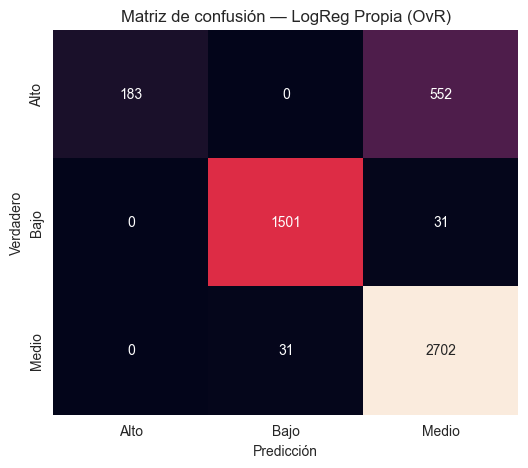

In [43]:
sns.set_style("whitegrid"); plt.rcParams["figure.figsize"]=(10,6)

try:
    TARGET = TARGET; train = train; test = test
except NameError:
    TARGET = "nivel_riesgo"
    base = os.path.abspath("..")
    train = pd.read_csv(os.path.join(base,"data","raw","datos_entrenamiento_riesgo.csv"))
    test  = pd.read_csv(os.path.join(base,"data","raw","datos_prueba_riesgo.csv"))
assert TARGET in train.columns

def _mode(s): s2=s.dropna(); return s2.value_counts().index[0] if len(s2) else np.nan
def fit_preprocessor(df):
    num=df.select_dtypes(include=[np.number]).columns.tolist()
    cat=df.select_dtypes(include=["object","category","bool"]).columns.tolist()
    num_meds=df[num].median() if num else pd.Series(dtype=float)
    cat_modes={c:_mode(df[c]) for c in cat}
    Xn=df[num].fillna(num_meds).astype(float) if num else pd.DataFrame(index=df.index)
    Xc=df[cat].copy(); [Xc.__setitem__(c, Xc[c].fillna(cat_modes[c])) for c in cat]
    Xc=pd.get_dummies(Xc.astype("category")) if cat else pd.DataFrame(index=df.index)
    if num: mu=Xn.mean(); sd=Xn.std(ddof=0).replace(0,1.0); Xn=(Xn-mu)/sd
    else: mu=pd.Series(dtype=float); sd=pd.Series(dtype=float)
    Xp=pd.concat([Xn.reset_index(drop=True),Xc.reset_index(drop=True)],axis=1)
    if Xp.shape[1]==0: Xp=pd.DataFrame(np.zeros((len(df),1)),columns=["dummy_0"])
    return {"num":num,"cat":cat,"num_meds":num_meds,"cat_modes":cat_modes,"mu":mu,"sd":sd,"levels":list(Xc.columns)}, Xp.values.astype(float)
def transform_preprocessor(df,pre):
    Xn=df[pre["num"]].fillna(pre["num_meds"]).astype(float) if pre["num"] else pd.DataFrame(index=df.index)
    Xc=df[pre["cat"]].copy() if pre["cat"] else pd.DataFrame(index=df.index)
    for c in pre["cat"]: Xc[c]=Xc[c].fillna(pre["cat_modes"][c])
    Xc=pd.get_dummies(Xc.astype("category")) if pre["cat"] else pd.DataFrame(index=df.index)
    Xc=Xc.reindex(columns=pre["levels"], fill_value=0)
    if pre["num"]: sd=pre["sd"].replace(0,1.0); Xn=(Xn-pre["mu"])/sd
    Xp=pd.concat([Xn.reset_index(drop=True),Xc.reset_index(drop=True)],axis=1)
    if Xp.shape[1]==0: Xp=pd.DataFrame(np.zeros((len(df),1)),columns=["dummy_0"])
    return Xp.values.astype(float)

y_train = train[TARGET].values; X_train_raw = train.drop(columns=[TARGET])
y_test  = test[TARGET].values;  X_test_raw  = test.drop(columns=[TARGET])
pre, X_train = fit_preprocessor(X_train_raw); X_test = transform_preprocessor(X_test_raw, pre)

def accuracy_score(y,yh): return float((np.asarray(y)==np.asarray(yh)).mean())
def f1_macro(y_true,y_pred):
    y_true,y_pred=np.asarray(y_true),np.asarray(y_pred); labels=np.unique(np.concatenate([y_true,y_pred])); f1s=[]
    for lab in labels:
        tp=np.sum((y_true==lab)&(y_pred==lab)); fp=np.sum((y_true!=lab)&(y_pred==lab)); fn=np.sum((y_true==lab)&(y_pred!=lab))
        p=tp/(tp+fp) if (tp+fp)>0 else 0; r=tp/(tp+fn) if (tp+fn)>0 else 0; f1s.append(2*p*r/(p+r) if (p+r)>0 else 0)
    return float(np.mean(f1s))
def confusion_matrix_(y_true,y_pred):
    labels=sorted(np.unique(np.concatenate([y_true,y_pred]))); idx={l:i for i,l in enumerate(labels)}
    M=np.zeros((len(labels),len(labels)),dtype=int)
    for t,p in zip(y_true,y_pred): M[idx[t],idx[p]]+=1
    return M,labels
def stratified_kfold_indices(y,n_splits=5,seed=42):
    rng=np.random.default_rng(seed); y=np.asarray(y); classes,yi=np.unique(y,return_inverse=True)
    buckets=[np.where(yi==c)[0] for c in range(len(classes))]; [rng.shuffle(b) for b in buckets]
    folds=[([],[]) for _ in range(n_splits)]
    for cls in buckets:
        parts=np.array_split(cls,n_splits)
        for i in range(n_splits):
            val=parts[i]
            for j in range(n_splits):
                (folds[j][1] if j==i else folds[j][0]).extend(val.tolist())
    return [(np.array(tr),np.array(va)) for tr,va in folds]

class LogRegBinary:
    def __init__(self, lr=0.05, epochs=700, reg=0.01):
        self.lr=lr; self.epochs=epochs; self.reg=reg
    def _sig(self,z): return 1/(1+np.exp(-z))
    def fit(self,X,y):
        X=np.c_[np.ones(X.shape[0]),X].astype(float); y=y.astype(float); self.W=np.zeros(X.shape[1],float)
        for _ in range(self.epochs):
            z=X@self.W; h=self._sig(z)
            grad=X.T@(h-y)/len(y); grad[1:]+=self.reg*self.W[1:]; self.W-=self.lr*grad
        return self
    def predict_proba(self,X):
        X=np.c_[np.ones(X.shape[0]),X].astype(float); return self._sig(X@self.W)

class OneVsRest:
    def __init__(self, base_cls, **kw): self.base=base_cls; self.kw=kw
    def fit(self,X,y):
        self.labels_=np.unique(y); self.models_=[]
        for lab in self.labels_:
            yb=(y==lab).astype(float); self.models_.append(self.base(**self.kw).fit(X,yb))
        return self
    def predict(self,X):
        S=np.column_stack([m.predict_proba(X) for m in self.models_]); return self.labels_[np.argmax(S,axis=1)]

accs,f1s=[],[]
for tr,va in stratified_kfold_indices(y_train,5,42):
    mdl=OneVsRest(LogRegBinary, lr=0.05, reg=0.01, epochs=700).fit(X_train[tr],y_train[tr])
    yh=mdl.predict(X_train[va]); accs.append(accuracy_score(y_train[va],yh)); f1s.append(f1_macro(y_train[va],yh))
res_df=pd.DataFrame([{"modelo":"LogReg Propia OvR (lr=0.05, reg=0.01, ep=700)","accuracy":np.mean(accs),"f1_macro":np.mean(f1s)}]).set_index("modelo")
try: display(res_df.style.background_gradient(cmap="Greys").format("{:.4f}"))
except: print(res_df.round(4))

final=OneVsRest(LogRegBinary, lr=0.05, reg=0.01, epochs=900).fit(X_train,y_train)
y_pred=final.predict(X_test)
print(f"Accuracy (TEST): {accuracy_score(y_test,y_pred):.4f} | F1-macro (TEST): {f1_macro(y_test,y_pred):.4f}")
cm,labels=confusion_matrix_(y_test,y_pred)
plt.figure(figsize=(6,5)); sns.heatmap(cm,annot=True,fmt="d",cbar=False,xticklabels=labels,yticklabels=labels)
plt.title("Matriz de confusión — LogReg Propia (OvR)"); plt.xlabel("Predicción"); plt.ylabel("Verdadero"); plt.show()


### 9.4. SVM

                                                    accuracy  f1_macro
modelo                                                                
SVM Propio ASGD + ECOC + L2 + PCA95/white (C=1,...    0.4628    0.4244
Accuracy (TEST): 0.4692 | F1-macro (TEST): 0.4280


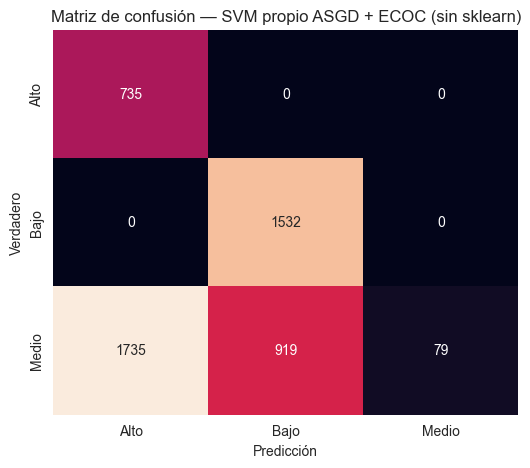

In [ ]:
sns.set_style("whitegrid"); plt.rcParams["figure.figsize"]=(10,6)

try:
    TARGET = TARGET; train = train; test = test
except NameError:
    TARGET = "nivel_riesgo"
    base = os.path.abspath("..")
    train = pd.read_csv(os.path.join(base, "data", "raw", "datos_entrenamiento_riesgo.csv"))
    test  = pd.read_csv(os.path.join(base, "data", "raw", "datos_prueba_riesgo.csv"))
assert TARGET in train.columns

def _mode(s): s2=s.dropna(); return s2.value_counts().index[0] if len(s2) else np.nan
def fit_preprocessor(df):
    num = df.select_dtypes(include=[np.number]).columns.tolist()
    cat = df.select_dtypes(include=["object","category","bool"]).columns.tolist()
    num_meds = df[num].median() if num else pd.Series(dtype=float)
    cat_modes = {c: _mode(df[c]) for c in cat}
    Xn = df[num].fillna(num_meds).astype(float) if num else pd.DataFrame(index=df.index)
    Xc = df[cat].copy()
    for c in cat: Xc[c] = Xc[c].fillna(cat_modes[c])
    Xc = pd.get_dummies(Xc.astype("category")) if cat else pd.DataFrame(index=df.index)
    if num:
        mu = Xn.mean(); sd = Xn.std(ddof=0).replace(0,1.0); Xn = (Xn - mu)/sd
    else:
        mu = pd.Series(dtype=float); sd = pd.Series(dtype=float)
    Xp = pd.concat([Xn.reset_index(drop=True), Xc.reset_index(drop=True)], axis=1)
    if Xp.shape[1]==0: Xp = pd.DataFrame(np.zeros((len(df),1)), columns=["dummy_0"])
    return {"num":num,"cat":cat,"num_meds":num_meds,"cat_modes":cat_modes,"mu":mu,"sd":sd,"levels":list(Xc.columns)}, Xp.values.astype(float)

def transform_preprocessor(df, pre):
    Xn = df[pre["num"]].fillna(pre["num_meds"]).astype(float) if pre["num"] else pd.DataFrame(index=df.index)
    Xc = df[pre["cat"]].copy() if pre["cat"] else pd.DataFrame(index=df.index)
    for c in pre["cat"]: Xc[c] = Xc[c].fillna(pre["cat_modes"][c])
    Xc = pd.get_dummies(Xc.astype("category")) if pre["cat"] else pd.DataFrame(index=df.index)
    Xc = Xc.reindex(columns=pre["levels"], fill_value=0)
    if pre["num"]:
        sd = pre["sd"].replace(0,1.0); Xn = (Xn - pre["mu"])/sd
    Xp = pd.concat([Xn.reset_index(drop=True), Xc.reset_index(drop=True)], axis=1)
    if Xp.shape[1]==0: Xp = pd.DataFrame(np.zeros((len(df),1)), columns=["dummy_0"])
    return Xp.values.astype(float)

y_train = train[TARGET].values
X_train_raw = train.drop(columns=[TARGET])
y_test  = test[TARGET].values
X_test_raw  = test.drop(columns=[TARGET])

pre, X_train = fit_preprocessor(X_train_raw)
X_test = transform_preprocessor(X_test_raw, pre)

def l2_normalize_rows(X, eps=1e-12):
    X = np.asarray(X, float)
    nrm = np.sqrt((X*X).sum(axis=1, keepdims=True))
    return X / np.maximum(nrm, eps)

X_train = l2_normalize_rows(X_train)
X_test  = l2_normalize_rows(X_test)

class PCAWhiten:
    def __init__(self, var_ratio=0.95):
        self.var_ratio = var_ratio
    def fit(self, X):
        X = np.asarray(X, float)
        self.mean_ = X.mean(axis=0, keepdims=True)
        Xc = X - self.mean_
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        var = S**2
        r = int(np.searchsorted(np.cumsum(var)/var.sum(), self.var_ratio) + 1)
        self.components_ = Vt[:r, :]
        self.scale_ = (S[:r] / np.sqrt(X.shape[0]-1))
        self.scale_[self.scale_==0] = 1.0
        return self
    def transform(self, X):
        Xc = np.asarray(X, float) - self.mean_
        Z = Xc @ self.components_.T
        return Z / self.scale_  

pca = PCAWhiten(0.95).fit(X_train)
X_train = pca.transform(X_train)
X_test  = pca.transform(X_test)

def accuracy_score_np(y, yhat): return float((np.asarray(y)==np.asarray(yhat)).mean())

def f1_macro_np(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    labels = np.unique(np.concatenate([y_true, y_pred])); f1s=[]
    for lab in labels:
        tp=np.sum((y_true==lab)&(y_pred==lab)); fp=np.sum((y_true!=lab)&(y_pred==lab)); fn=np.sum((y_true==lab)&(y_pred!=lab))
        p = tp/(tp+fp) if (tp+fp)>0 else 0.0
        r = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1s.append(2*p*r/(p+r) if (p+r)>0 else 0.0)
    return float(np.mean(f1s))

def confusion_matrix_(y_true, y_pred):
    labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
    idx = {l:i for i,l in enumerate(labels)}
    M = np.zeros((len(labels),len(labels)), dtype=int)
    for t,p in zip(y_true, y_pred): M[idx[t], idx[p]] += 1
    return M, labels

def stratified_kfold_indices(y, n_splits=5, seed=42):
    rng=np.random.default_rng(seed); y=np.asarray(y)
    classes, yi = np.unique(y, return_inverse=True)
    buckets=[np.where(yi==c)[0] for c in range(len(classes))]
    for b in buckets: rng.shuffle(b)
    folds=[([],[]) for _ in range(n_splits)]
    for cls_idx in buckets:
        parts=np.array_split(cls_idx, n_splits)
        for i in range(n_splits):
            val=parts[i]
            for j in range(n_splits):
                (folds[j][1] if j==i else folds[j][0]).extend(val.tolist())
    return [(np.array(tr), np.array(va)) for tr,va in folds]

class SVM_ASGDAveraged:
    def __init__(self, C=1.0, lr0=0.05, epochs=5):
        self.C=C; self.lr0=lr0; self.epochs=epochs
    def fit(self, X, y):
        X = np.asarray(X, float)
        y = np.where(np.asarray(y)==1, 1.0, -1.0)
        self.W = np.zeros(X.shape[1], float)
        W_sum = np.zeros_like(self.W); cnt = 0
        pos = (y==1).sum(); neg = (y==-1).sum()
        w_pos = 0.5/max(pos,1); w_neg = 0.5/max(neg,1)
        t = 1
        for _ in range(self.epochs):
            for i in range(len(X)):
                eta = self.lr0 / np.sqrt(t)  
                t += 1
                w_i = w_pos if y[i]==1 else w_neg
                margin = y[i] * (X[i] @ self.W)
                if margin >= 1:
                    self.W -= eta * (2.0 * self.W) * w_i
                else:
                    self.W -= eta * (2.0 * self.W - self.C * y[i] * X[i]) * w_i
                W_sum += self.W; cnt += 1
        self.W_avg = W_sum / max(cnt,1)
        return self
    def decision_function(self, X):
        return np.asarray(X, float) @ self.W_avg

class ECOC:
    def __init__(self, base_cls, n_bits=15, seed=123, **kw):
        self.base = base_cls; self.kw = kw; self.n_bits=n_bits; self.seed=seed
    def fit(self, X, y):
        self.labels_ = np.unique(y)
        rng = np.random.default_rng(self.seed)
        C = rng.choice([-1, 1], size=(len(self.labels_), self.n_bits))
        for j in range(self.n_bits):
            if np.all(C[:,j]==1) or np.all(C[:,j]==-1):
                C[rng.integers(0,len(self.labels_)), j] *= -1
        self.code_ = C
        self.models_ = []
        for j in range(self.n_bits):
            yb = np.array([C[np.where(self.labels_==lab)[0][0], j] for lab in y], float)
            yb = np.where(yb==1, 1.0, -1.0)
            mdl = self.base(**self.kw).fit(X, yb)
            self.models_.append(mdl)
        return self
    def predict(self, X):
        S = np.column_stack([m.decision_function(X) for m in self.models_])
        signS = np.sign(S); signS[signS==0] = 1
        best = []
        for i in range(S.shape[0]):
            errs = ((signS[i][None,:] - self.code_)**2).sum(axis=1)
            j = np.argmin(errs)
            best.append(self.labels_[j])
        return np.array(best)

def cv_eval(X, y, Xtest, ytest):
    accs, f1s = [], []
    for tr,va in stratified_kfold_indices(y, n_splits=5, seed=42):
        mdl = ECOC(SVM_ASGDAveraged, n_bits=15, seed=123, C=1.0, lr0=0.05, epochs=5)
        mdl.fit(X[tr], y[tr])
        yhat = mdl.predict(X[va])
        accs.append(accuracy_score_np(y[va], yhat))
        f1s.append(f1_macro_np(y[va], yhat))
    df = pd.DataFrame([{
        "modelo": "SVM Propio ASGD + ECOC + L2 + PCA95/white (C=1, lr0=0.05, ep=5, bits=15)",
        "accuracy": np.mean(accs),
        "f1_macro": np.mean(f1s)
    }]).set_index("modelo")
    final = ECOC(SVM_ASGDAveraged, n_bits=15, seed=123, C=1.0, lr0=0.05, epochs=5).fit(X, y)
    ypred = final.predict(Xtest)
    acc_t = accuracy_score_np(ytest, ypred)
    f1_t  = f1_macro_np(ytest, ypred)
    return df, ypred, acc_t, f1_t

res_df, y_pred, acc_t, f1_t = cv_eval(X_train, y_train, X_test, y_test)

try:
    display(res_df.style.background_gradient(cmap="Greys").format("{:.4f}"))
except:
    print(res_df.round(4))

print(f"Accuracy (TEST): {acc_t:.4f} | F1-macro (TEST): {f1_t:.4f}")

cm, labels = confusion_matrix_(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Matriz de confusión — SVM propio ASGD + ECOC (sin sklearn)")
plt.xlabel("Predicción"); plt.ylabel("Verdadero")
plt.show()
